# Setup

In [1339]:
# widen jupyter notebook window
from IPython.display import display, HTML
display(HTML("<style>.container {width:95% !important; }</style>"))

# check environment
import os
print(f'Conda Environment: ' + os.environ['CONDA_DEFAULT_ENV'])

from platform import python_version
print(f'python version: {python_version()}')

Conda Environment: rich_clust
python version: 3.9.12


In [2]:
import os
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import natsort

import torch
# from kymatio.torch import Scattering2D

import gc
import time
import functools
import multiprocessing as mp


In [3]:
# params = {
#     'dir_github': r'/media/rich/Home_Linux_partition/github_repos/',
#     'dir_allOuterFolders': r"/media/rich/bigSSD/other lab data/Harnett_lab/ROI_Tracking/Vincent_Valerio/4th_email/AllStatFiles/rbp10",
#     'pathSuffixToStat': 'plane1/stat.npy',
#     'pathSuffixToOps': 'plane1/ops.npy',
#     'pref_use_NN_distances': True,
#     'use_GPU': True,
#     'pref_blurROIs': True,
#     'params_blur': {
#         'kernel_size': 7, # Edge length of kernel image. Make odd number.
#         'kernel_width': 2.1, # width of 1 full cosine cycle for the 2d cosine kernel. Use width=2 for a single pixel.
#     },
#     'mask_power': 1, ## This parameter determines how 'binary'-looking masks are. Small values = more binary. Large values weight bright pixels more. mask_scaled = mask**mask_power
#     'params_dIOU': {
#         'algorithm': 'brute', ## Can be 'brute', 'auto', or anything from sklearn.neighbors.NearestNeighbors
#         'n_neighbors': 'full', ## Can either be an int or 'full', in which case the output will not be sparse
#     }
# }

In [4]:
dir_github = Path(r'/media/rich/Home_Linux_partition/github_repos/').resolve()

import sys
sys.path.append(str(dir_github))

In [5]:
# device = torch_helpers.set_device(use_GPU=params['use_GPU'])

In [6]:
%load_ext autoreload
%autoreload 2
from ROICaT.tracking import data_importing, visualization, alignment, blurring, helpers, ROInet, scatteringWaveletTransformer, similarity_graph, clustering

In [7]:
%matplotlib notebook

# Import paths

In [8]:
def print_list(l):
    for item in l:
        print(item)

In [9]:
# dir_allOuterFolders = Path(r"/media/rich/bigSSD/other lab data/Harnett_lab/ROI_Tracking/Vincent_Valerio/4th_email/AllStatFiles/rbp16").resolve()
dir_allOuterFolders = Path(r"/media/rich/bigSSD/other lab data/Harnett_lab/ROI_Tracking/").resolve()

folders_allSessions = natsort.natsorted(helpers.get_dir_contents(dir_allOuterFolders)[0])

dir_allS2pFolders = [dir_allOuterFolders / folder for folder in folders_allSessions]

pathSuffixToStat = 'plane0/stat.npy'
pathSuffixToOps = 'plane0/ops.npy'

paths_allStat = np.array([path / pathSuffixToStat for path in dir_allS2pFolders])[:]
paths_allOps  = np.array([path / pathSuffixToOps for path in dir_allS2pFolders])[:]

print(f'folder names of all sessions: \n{folders_allSessions}')
print(f'paths to all stat files: \n{paths_allStat}')


folder names of all sessions: 
['D1', 'D2', 'D3', 'D4', 'D5', 'D6', 'D7', 'D8', 'D9', 'D10', 'D11', 'D12', 'D13', 'D14']
paths to all stat files: 
[PosixPath('/media/rich/bigSSD/other lab data/Harnett_lab/ROI_Tracking/Vincent_Valerio/4th_email/AllStatFiles/rbp16/D1/plane0/stat.npy')
 PosixPath('/media/rich/bigSSD/other lab data/Harnett_lab/ROI_Tracking/Vincent_Valerio/4th_email/AllStatFiles/rbp16/D2/plane0/stat.npy')
 PosixPath('/media/rich/bigSSD/other lab data/Harnett_lab/ROI_Tracking/Vincent_Valerio/4th_email/AllStatFiles/rbp16/D3/plane0/stat.npy')
 PosixPath('/media/rich/bigSSD/other lab data/Harnett_lab/ROI_Tracking/Vincent_Valerio/4th_email/AllStatFiles/rbp16/D4/plane0/stat.npy')
 PosixPath('/media/rich/bigSSD/other lab data/Harnett_lab/ROI_Tracking/Vincent_Valerio/4th_email/AllStatFiles/rbp16/D5/plane0/stat.npy')
 PosixPath('/media/rich/bigSSD/other lab data/Harnett_lab/ROI_Tracking/Vincent_Valerio/4th_email/AllStatFiles/rbp16/D6/plane0/stat.npy')
 PosixPath('/media/rich/bigSSD/

# Import data

In [10]:
data = data_importing.Data_suite2p(
    paths_statFiles=paths_allStat,
    paths_opsFiles=paths_allOps,
    um_per_pixel=2.0,
    new_or_old_suite2p='new',
    verbose=True,
)

data.import_statFiles();

data.import_ROI_centeredImages(
    out_height_width=[72,72],
    max_footprint_width=1025,
);

data.import_FOV_images(
    type_meanImg='meanImgE',
    images=None
);

data.import_ROI_spatialFootprints(workers=-1);

Starting: Importing spatial footprints from stat files
Completed: Imported 14 stat files into class as self.statFiles. Total number of ROIs: 51169. Number of ROI from each file: [3047, 2847, 2779, 4324, 4264, 3369, 3514, 3620, 4375, 3768, 4829, 2994, 3439, 4000]


14it [00:02,  6.03it/s]


Converted 14 spatial footprint files into small centered images in self.ROI_images.
Imported 14 FOV images into class as self.FOV_images
Importing spatial footprints from stat files.
Imported 14 sessions of spatial footprints into sparse arrays.


<IPython.core.display.Javascript object>


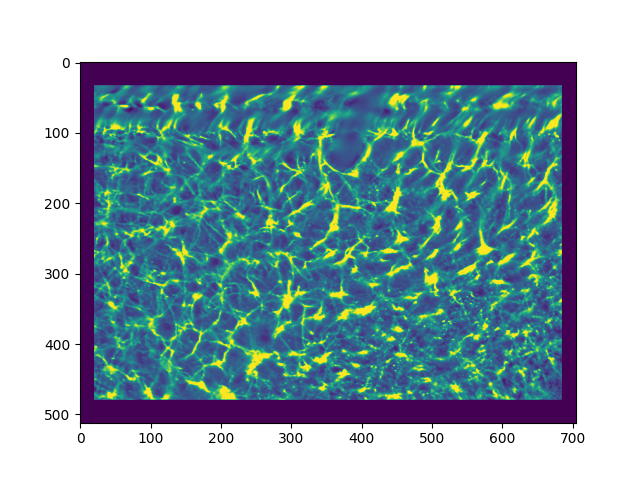

interactive(children=(IntSlider(value=0, description='i_frame', max=13), Output()), _dom_classes=('widget-inte…

<IPython.core.display.Javascript object>


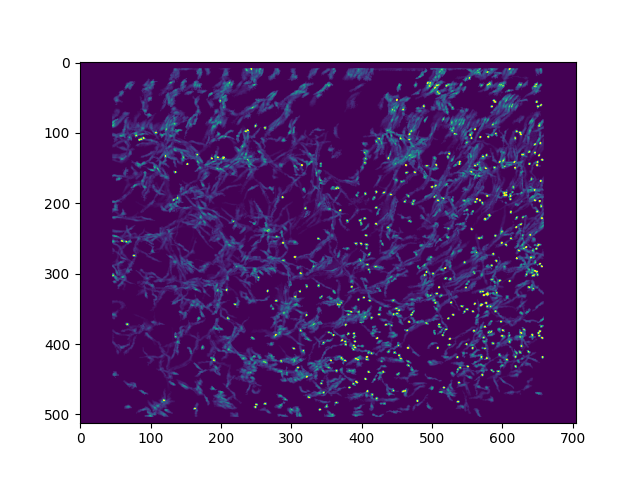

interactive(children=(IntSlider(value=0, description='i_frame', max=13), Output()), _dom_classes=('widget-inte…

<IPython.core.display.Javascript object>


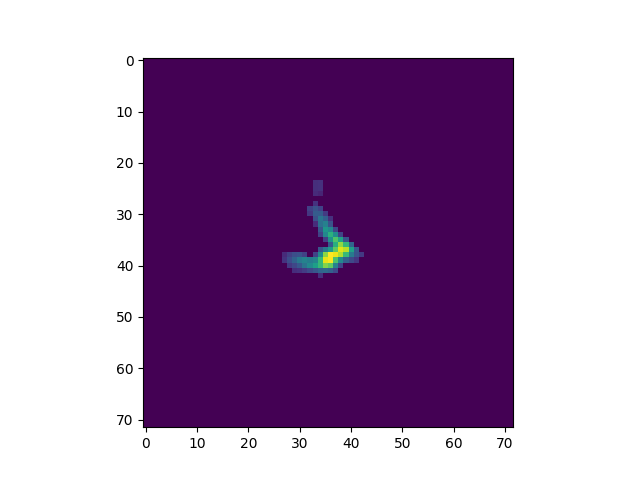

interactive(children=(IntSlider(value=0, description='i_frame', max=51168), Output()), _dom_classes=('widget-i…

In [69]:
%matplotlib notebook

visualization.display_toggle_image_stack(data.FOV_images)

visualization.display_toggle_image_stack([sf.max(0).reshape(data.FOV_height, data.FOV_width).toarray() for sf in data.spatialFootprints], clim=[0,0.1])

visualization.display_toggle_image_stack(np.concatenate(data.ROI_images, axis=0))

# Alignment

In [30]:
use_CLAHE = False
idx_session_template = 0.5
idx_st = int(idx_session_template * data.n_sessions) if type(idx_session_template) is float else idx_session_template

FOV_images = [alignment.clahe(im, grid_size=10, clipLimit=0, normalize=True) for im in pcr.ims_registered[:]] if use_CLAHE else data.FOV_images

pcr = alignment.PhaseCorrelation_registration()

pcr.set_spectral_mask(
    freq_highPass=0.01,
    freq_lowPass=0.3,
    im_shape=(data.FOV_height, data.FOV_width)
)

pcr.register(
    im_template=FOV_images[idx_st],
    ims_moving=FOV_images
);

aligner = alignment.Alinger(
    method='createOptFlow_DeepFlow',
    kwargs_method=None
)

aligner.register_ROIs(
    templateFOV=pcr.ims_registered[idx_st],
    FOVs=pcr.ims_registered,
    ROIs=data.spatialFootprints,
    shifts=pcr.shifts[:],
    return_sparse=True,
    normalize=True,
);

100%|███████████████████████████████████████████| 14/14 [04:36<00:00, 19.71s/it]


<IPython.core.display.Javascript object>


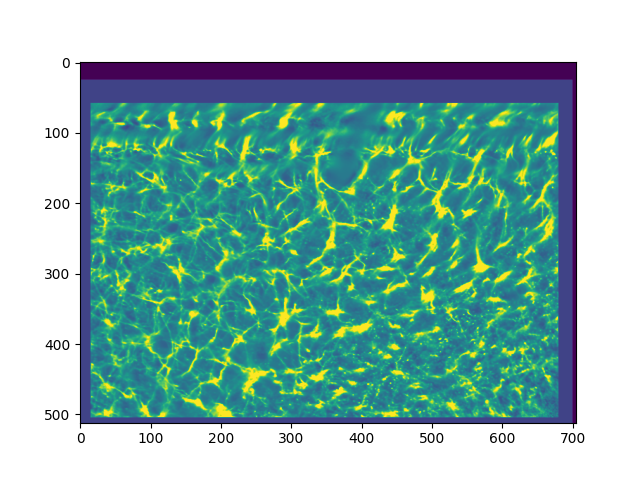

interactive(children=(IntSlider(value=0, description='i_frame', max=13), Output()), _dom_classes=('widget-inte…

<IPython.core.display.Javascript object>


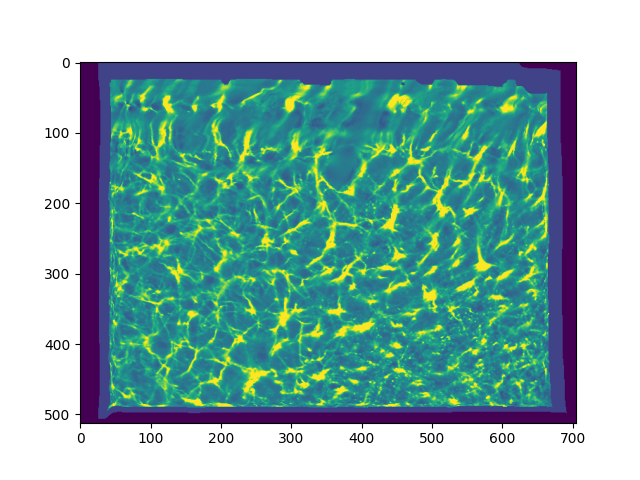

interactive(children=(IntSlider(value=0, description='i_frame', max=13), Output()), _dom_classes=('widget-inte…

<IPython.core.display.Javascript object>


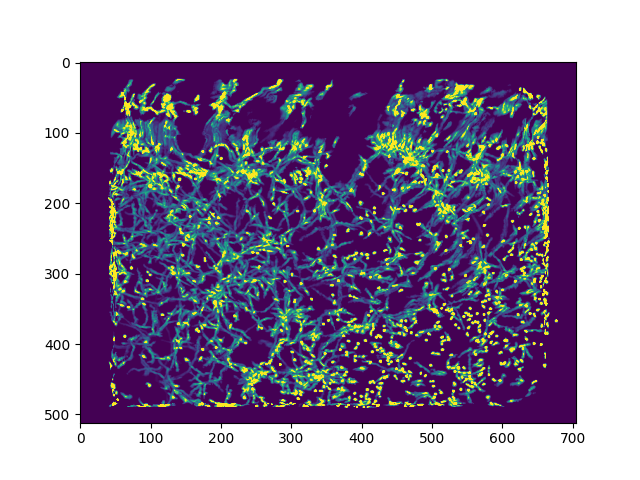

interactive(children=(IntSlider(value=0, description='i_frame', max=13), Output()), _dom_classes=('widget-inte…

<IPython.core.display.Javascript object>


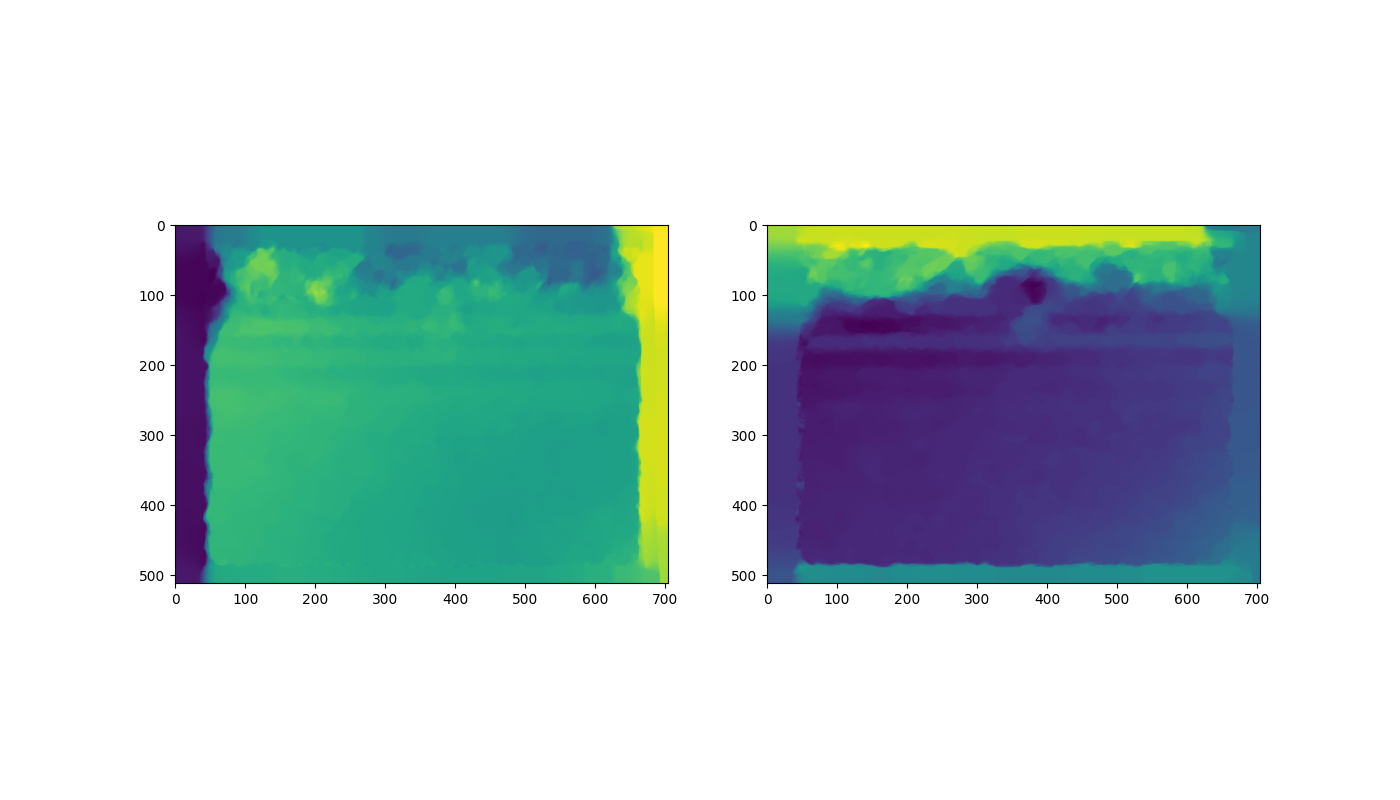

interactive(children=(IntSlider(value=0, description='i_frame', max=13), Output()), _dom_classes=('widget-inte…

In [31]:
%matplotlib notebook

visualization.display_toggle_image_stack(pcr.ims_registered[:])

visualization.display_toggle_image_stack(aligner.FOVs_aligned)
visualization.display_toggle_image_stack(aligner.get_ROIsAligned_maxIntensityProjection(), clim=[0,0.03])
visualization.display_toggle_2channel_image_stack(aligner.flows)

## Blur ROIs (optional)

In [32]:
blurrer = blurring.ROI_Blurrer(
    frame_shape=(data.FOV_height, data.FOV_width),
    kernel_halfWidth=2,
    plot_kernel=False,
)

blurrer.blur_ROIs(
    spatialFootprints=aligner.ROIs_aligned[:],
)

Preparing the Toeplitz convolution matrix
Performing convolution for blurring


<IPython.core.display.Javascript object>


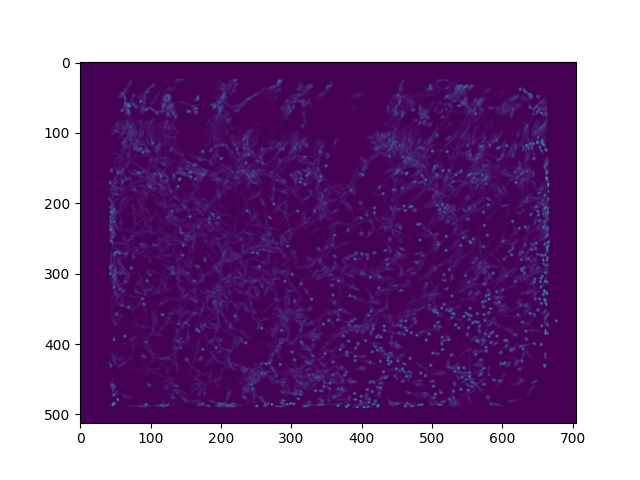

interactive(children=(IntSlider(value=0, description='i_frame', max=13), Output()), _dom_classes=('widget-inte…

In [33]:
%matplotlib notebook
visualization.display_toggle_image_stack(blurrer.get_ROIsBlurred_maxIntensityProjection())

## Neural network embedding distances

In [19]:
# data.um_per_pixel = 2.0

In [46]:

hash_dict_true = {
    'params': ('params.json', '68cf1bd47130f9b6d4f9913f86f0ccaa'),
    'model': ('model.py', '61c85529b7aa33e0dfadb31ee253a7e1'),
    'state_dict': ('ConvNext_tiny__1_0_best__simCLR.pth', '3287e001ff28d07ada2ae70aa7d0a4da'),
}

roinet = ROInet.ROInet_embedder(
    device='cuda:0',
    dir_networkFiles='/home/rich/Downloads/ROInet',
    
#     download_from_gDrive='force_download',
#     download_from_gDrive='force_local',
    download_from_gDrive='check_local_first',
    gDriveID='1D2Qa-YUNX176Q-wgboGflW0K6un7KYeN',
    hash_dict_networkFiles=hash_dict_true,
#     hash_dict_networkFiles=None,
    forward_pass_version='latent',
    verbose=True,
)

Successful hash comparison. Found matching files: {'params': '/home/rich/Downloads/ROInet/params.json', 'model': '/home/rich/Downloads/ROInet/model.py', 'state_dict': '/home/rich/Downloads/ROInet/ConvNext_tiny__1_0_best__simCLR.pth'}
Imported model from /home/rich/Downloads/ROInet/model.py
Loaded params_model from /home/rich/Downloads/ROInet/params.json


/media/rich/OS/Users/Richard/Linux_stuff_on_OS/conda_envs/envs/rich_clust/lib/python3.9/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  warnings.warn(
/media/rich/OS/Users/Richard/Linux_stuff_on_OS/conda_envs/envs/rich_clust/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=ConvNeXt_Tiny_Weights.IMAGENET1K_V1`. You can also use `weights=ConvNeXt_Tiny_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Generated network using params_model
Loaded state_dict into network from /home/rich/Downloads/ROInet/ConvNext_tiny__1_0_best__simCLR.pth
Loaded network onto device cuda:0


In [47]:
roinet.generate_dataloader(
    ROI_images=data.ROI_images,
    um_per_pixel=data.um_per_pixel,
    pref_plot=False,
    batchSize_dataloader=8,
    pinMemory_dataloader=True,
    numWorkers_dataloader=mp.cpu_count(),
    persistentWorkers_dataloader=True,
    prefetchFactor_dataloader=2,    
);

Starting: resizing ROIs


100%|███████████████████████████████████████████| 14/14 [00:14<00:00,  1.05s/it]


Completed: resizing ROIs
Defined image transformations: Sequential(
  (0): ScaleDynamicRange(scaler_bounds=(0, 1))
  (1): Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=None)
  (2): TileChannels(dim=0)
)
Defined dataset
Defined dataloader


<IPython.core.display.Javascript object>


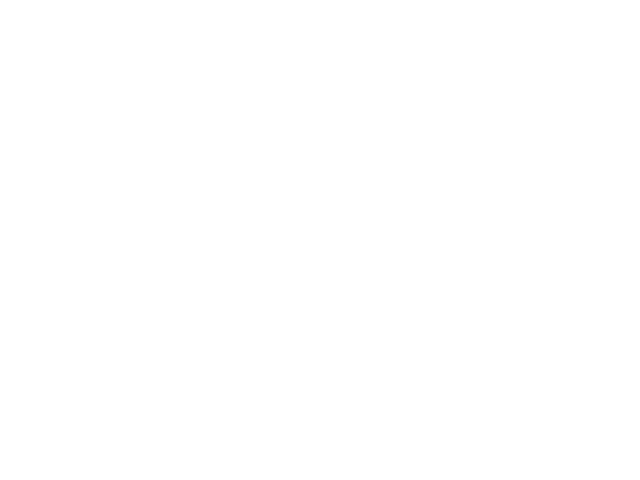

interactive(children=(IntSlider(value=0, description='i_frame', max=51168), Output()), _dom_classes=('widget-i…

In [48]:
%matplotlib notebook
visualization.display_toggle_image_stack(roinet.ROI_images_rs)

In [49]:
roinet.generate_latents();


starting: running data through network


  0%|                                                  | 0/6397 [00:00<?, ?it/s]/media/rich/OS/Users/Richard/Linux_stuff_on_OS/conda_envs/envs/rich_clust/lib/python3.9/site-packages/torch/nn/modules/module.py:1130: UserWarning: operator() profile_node %253 : int = prim::profile_ivalue(%out_dtype.1)
 does not have profile information (Triggered internally at  ../torch/csrc/jit/codegen/cuda/graph_fuser.cpp:104.)
  return forward_call(*input, **kwargs)
/media/rich/OS/Users/Richard/Linux_stuff_on_OS/conda_envs/envs/rich_clust/lib/python3.9/site-packages/torch/nn/modules/module.py:1130: UserWarning: operator() profile_node %253 : int = prim::profile_ivalue(%out_dtype.1)
 does not have profile information (Triggered internally at  ../torch/csrc/jit/codegen/cuda/graph_fuser.cpp:104.)
  return forward_call(*input, **kwargs)
/media/rich/OS/Users/Richard/Linux_stuff_on_OS/conda_envs/envs/rich_clust/lib/python3.9/site-packages/torch/nn/modules/module.py:1130: UserWarning: operator() profile_node 

/media/rich/OS/Users/Richard/Linux_stuff_on_OS/conda_envs/envs/rich_clust/lib/python3.9/site-packages/torch/nn/modules/module.py:1130: UserWarning: operator() profile_node %253 : int = prim::profile_ivalue(%out_dtype.1)
 does not have profile information (Triggered internally at  ../torch/csrc/jit/codegen/cuda/graph_fuser.cpp:104.)
  return forward_call(*input, **kwargs)
/media/rich/OS/Users/Richard/Linux_stuff_on_OS/conda_envs/envs/rich_clust/lib/python3.9/site-packages/torch/nn/modules/module.py:1130: UserWarning: operator() profile_node %253 : int = prim::profile_ivalue(%out_dtype.1)
 does not have profile information (Triggered internally at  ../torch/csrc/jit/codegen/cuda/graph_fuser.cpp:104.)
  return forward_call(*input, **kwargs)
/media/rich/OS/Users/Richard/Linux_stuff_on_OS/conda_envs/envs/rich_clust/lib/python3.9/site-packages/torch/nn/modules/module.py:1130: UserWarning: operator() profile_node %253 : int = prim::profile_ivalue(%out_dtype.1)
 does not have profile informati

completed: running data through network


In [50]:
gc.collect()
torch.cuda.empty_cache()
gc.collect()
torch.cuda.empty_cache()

## Scattering wavelet embedding distances

In [51]:
swt = scatteringWaveletTransformer.SWT(
    kwargs_Scattering2D={'J': 2, 'L': 2}, 
    image_shape=data.ROI_images[0].shape[1:3], 
    device='cuda:0'
)

swt.transform(
    ROI_images=np.concatenate(data.ROI_images, axis=0),
    batch_size=100,
);

SWT initialized
Starting: SWT transform on ROIs


  0%|                                                | 0/511.69 [00:00<?, ?it/s]/media/rich/OS/Users/Richard/Linux_stuff_on_OS/conda_envs/envs/rich_clust/lib/python3.9/site-packages/tqdm/std.py:533: TqdmWarning: clamping frac to range [0, 1]
  full_bar = Bar(frac,
100%|█████████████████████████████████████| 512/511.69 [00:02<00:00, 211.30it/s]

Completed: SWT transform on ROIs


In [52]:
gc.collect()
torch.cuda.empty_cache()
gc.collect()
torch.cuda.empty_cache()


## Compute similarities

In [79]:
sim = similarity_graph.ROI_graph(
    n_workers=-1,
    frame_height=data.FOV_height,
    frame_width=data.FOV_width,
#     block_height=data.FOV_height,
#     block_width=data.FOV_width,
    block_height=128,
    block_width=128,
    overlapping_width_Multiplier=0.0,
    algorithm_nearestNeigbors_spatialFootprints='brute',
    verbose=True,
)

<IPython.core.display.Javascript object>


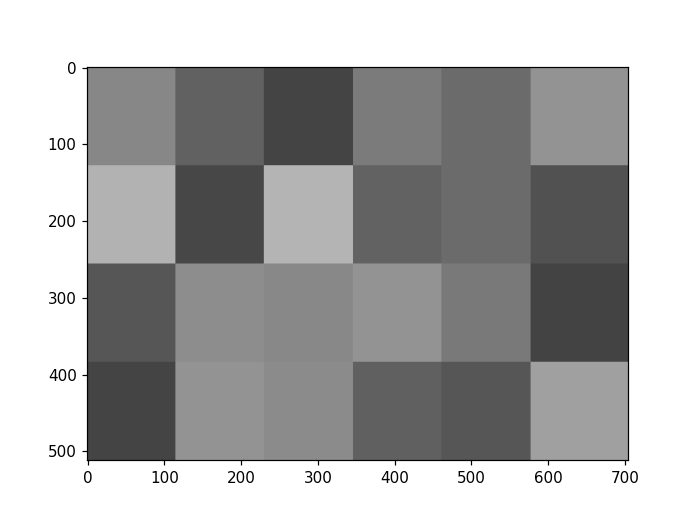

In [80]:
sim.visualize_blocks()

In [81]:
s_sf, s_NN, s_SWT, s_sesh = sim.compute_similarity_blockwise(
    spatialFootprints=blurrer.ROIs_blurred,
#     spatialFootprints=aligner.ROIs_aligned,
    features_NN=roinet.latents,
    features_SWT=swt.latents,
    ROI_session_bool=data.sessionID_concat,
    spatialFootprint_maskPower=0.8,
);

Computing pairwise similarity between ROIs...


100%|███████████████████████████████████████████| 24/24 [00:57<00:00,  2.38s/it]


Joining blocks into full similarity matrices...


In [576]:
sim.make_normalized_similarities(
    centers_of_mass=data.get_midCoords(),
    features_NN=roinet.latents,
    features_SWT=swt.latents,
#     features_SWT=None,
    k_max=4000,
    k_min=100,
    algo_NN='kd_tree',
)

Normalizing Neural Network similarity scores...


100%|██████████████████████████████████| 51169/51169 [00:03<00:00, 14388.54it/s]


Normalizing SWT similarity scores...


100%|████████████████████████████████████| 51169/51169 [02:32<00:00, 336.12it/s]


# Clustering

Making conjunctive distance matrix...


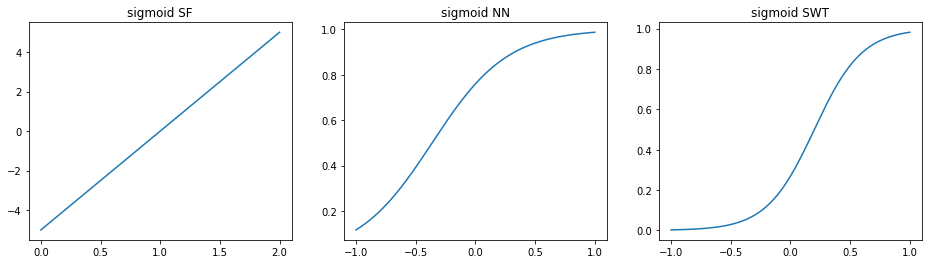

In [621]:
%matplotlib inline
clusterer = clustering.Clusterer()

clusterer.make_conjunctive_distance_matrix(
    s_sf=sim.s_sf,
    s_NN_z=sim.s_NN_z,
    s_SWT_z=sim.s_SWT_z,
#     s_SWT_z=None,
    power_sf= 1.1283032403078765,
    power_NN=0.4728813120992312,
    power_SWT=1,
    p_norm=-8.81737558074308,
#     sig_sf_kwargs={'mu':1.0, 'b':0.5},
    sig_sf_kwargs=None,
    sig_NN_kwargs={'mu':-1.808633200907082, 'b':0.635134494015924,},
    sig_SWT_kwargs={'mu':1, 'b':1},
    plot_sigmoid=True,
)

In [667]:
best_params

{'power_sf': 0.3582257559364649,
 'power_NN': 1.421879514461546,
 'power_SWT': 0.24238872632953112,
 'p_norm': -6.0714284193548105,
 'sig_NN_kwargs': {'mu': -2.934935684773385, 'b': 4.120407687873644},
 'sig_SWT_kwargs': {'mu': -3.8377466317761715, 'b': 3.261410173836138}}

In [1346]:
clusterer = clustering.Clusterer(
    s_sf=sim.s_sf,
    s_NN_z=sim.s_NN_z,
    s_SWT_z=sim.s_SWT_z,
    s_sesh=sim.s_sesh,
)

kwargs_makeConjunctiveDistanceMatrix_best = clusterer.find_optimal_parameters_for_pruning(
    n_bins=100,
    find_parameters_automatically=True,
    kwargs_findParameters={
        'n_patience': 100,
        'tol_frac': 0.05,
        'max_trials': 350,
        'max_duration': 60*10,
        'verbose': False,
    },
    n_jobs_findParameters=-1,    
#     fallback_d_cutoff=0.5,
#     plot_pref=True,
)

Finding parameters using automated hyperparameter tuning...
Best value found: 0.03211018815636635 with parameters {'power_SF': 2.1225515540392443, 'power_NN': 0.15239439045189962, 'power_SWT': 0.8982503595091178, 'p_norm': -8.653077456584777, 'sig_SF_kwargs': {'mu': 0.2952369397306444, 'b': 1.9170557475931949}, 'sig_NN_kwargs': {'mu': 0.344580616681926, 'b': 1.7001621655664223}, 'sig_SWT_kwargs': {'mu': 0.16616200198055492, 'b': 0.12122283467970872}}


In [1347]:
clusterer.best_params

{'power_SF': 2.1225515540392443,
 'power_NN': 0.15239439045189962,
 'power_SWT': 0.8982503595091178,
 'p_norm': -8.653077456584777,
 'sig_SF_kwargs': {'mu': 0.2952369397306444, 'b': 1.9170557475931949},
 'sig_NN_kwargs': {'mu': 0.344580616681926, 'b': 1.7001621655664223},
 'sig_SWT_kwargs': {'mu': 0.16616200198055492, 'b': 0.12122283467970872}}

<IPython.core.display.Javascript object>


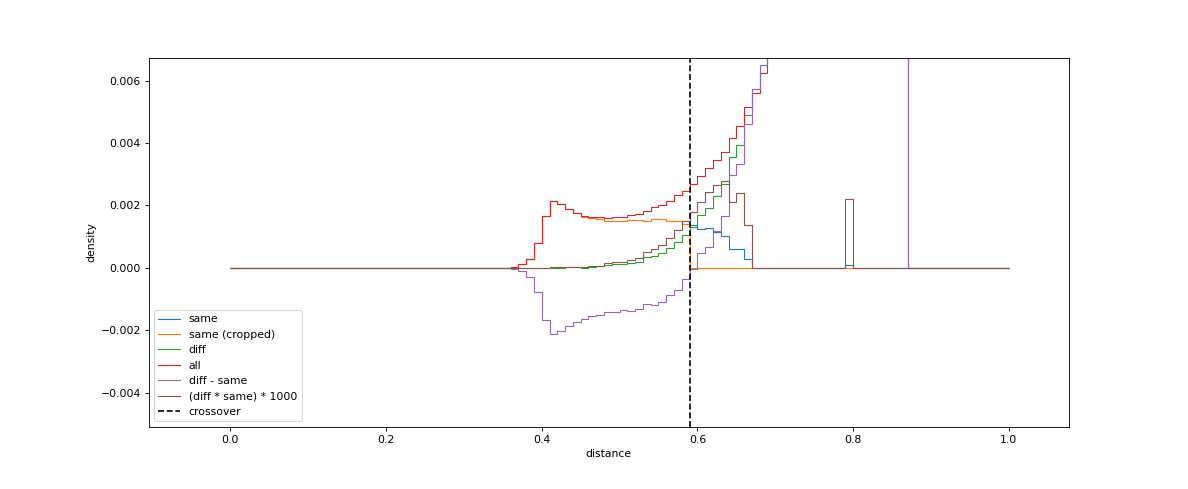

In [1348]:
clusterer.plot_distSame()

In [1350]:
clusterer.make_pruned_similarity_graphs(
    kwargs_makeConjunctiveDistanceMatrix=kwargs_makeConjunctiveDistanceMatrix_best
)

<IPython.core.display.Javascript object>


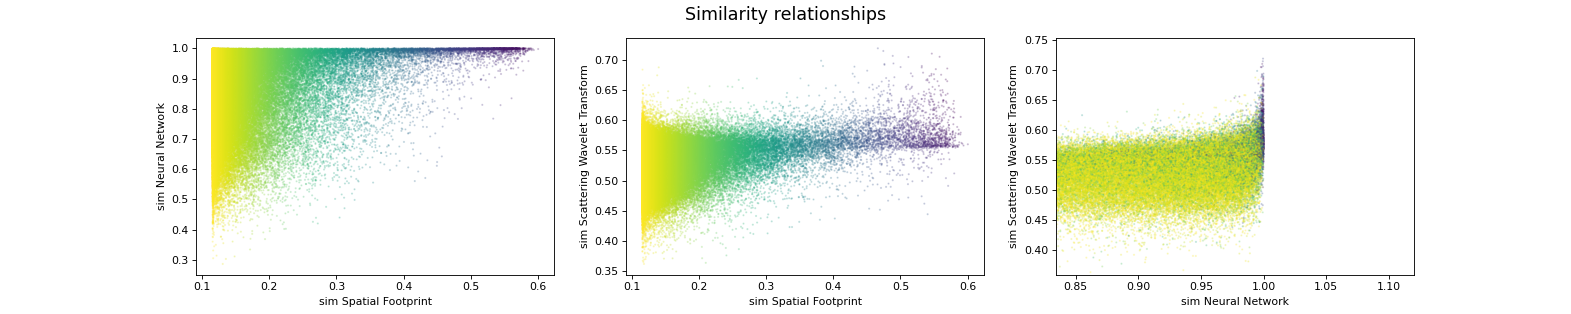

In [1374]:
clusterer.plot_similarity_relationships(
    plots_to_show=[1,2,3], 
    max_samples=100000, 
    kwargs_scatter={'s':1, 'alpha':0.2},
    kwargs_makeConjunctiveDistanceMatrix=kwargs_makeConjunctiveDistanceMatrix_best,
#     kwargs_makeConjunctiveDistanceMatrix={
#         'power_SF': 1.0,
#         'power_NN': 1.0,
#         'power_SWT': 0.1,
#         'p_norm': -4.0,
#         'sig_SF_kwargs': {'mu':0.5, 'b':4},
# #         'sig_SF_kwargs': None,
#         'sig_NN_kwargs': {'mu':0.5, 'b':1.5},
#         'sig_SWT_kwargs': {'mu':0.5, 'b':0.5},
#     },
);

In [1375]:
kwargs_makeConjunctiveDistanceMatrix_best

{'power_SF': 2.1225515540392443,
 'power_NN': 0.15239439045189962,
 'power_SWT': 0.8982503595091178,
 'p_norm': -8.653077456584777,
 'sig_SF_kwargs': {'mu': 0.2952369397306444, 'b': 1.9170557475931949},
 'sig_NN_kwargs': {'mu': 0.344580616681926, 'b': 1.7001621655664223},
 'sig_SWT_kwargs': {'mu': 0.16616200198055492, 'b': 0.12122283467970872}}

In [1376]:
clusterer.make_pruned_similarity_graphs(
    kwargs_makeConjunctiveDistanceMatrix=kwargs_makeConjunctiveDistanceMatrix_best
)

In [1385]:
dConj, sSF_data, sNN_data, sSWT_data, sConj_data = clusterer.make_conjunctive_distance_matrix(
    s_sf=clusterer.s_sf_pruned,
    s_NN=clusterer.s_NN_pruned,
    s_SWT=clusterer.s_SWT_pruned,
    **kwargs_makeConjunctiveDistanceMatrix_best
)


<IPython.core.display.Javascript object>


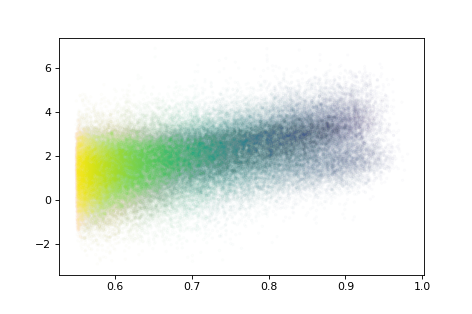

In [1391]:
plt.figure()
plt.scatter(
    clusterer.s_sf_pruned.data[:100000], 
    clusterer.s_NN_pruned.data[:100000], 
    c=dConj.data[:100000], 
    s=5, 
    alpha=0.01
)
# plt.scatter(clusterer.s_sf_pruned.data[:30000], clusterer.s_NN_pruned.data[:30000], s=5, alpha=0.01)

# # plt.scatter(clusterer.s_SWT_z.data[:1000000], clusterer.s_NN_z.data[:1000000], s=5, alpha=0.01)
# plt.scatter(clusterer.s_SWT_pruned.data[:30000], clusterer.s_NN_pruned.data[:30000], s=5, alpha=0.01)


In [1416]:
clusterer.fit(
    session_bool=data.sessionID_concat,
    min_cluster_size=2,
    split_intraSession_clusters=True,
    discard_failed_pruning=True,
    d_conj=dConj,
    d_cut=clusterer.d_cutoff,
    d_step=0.05,
)

Clustering...
Fitting HDBSCAN...
Splitting up clusters with multiple ROIs per session...
RH WARNING: Redundant session cluster splitting did not complete fully. Distance walk failed at 'd_cut':-0.010000026226043665.
Setting all clusters with redundant ROIs to label: -1.


array([  23,   -1, 2481, ...,   -1, 4347,   -1])

In [1395]:
clusterer.labels

array([  23,   -1, 2481, ...,   -1, 4347,   -1])

In [1433]:
from functools import partial

In [1544]:
def fit_automated(
    trial,
    session_bool=data.sessionID_concat,
    min_cluster_size=2,
    split_intraSession_clusters=False,
    discard_failed_pruning=True,
    d_conj=None,
    d_cut=None,
    d_step=0.05,
):
   
    d, _, _, _, _ = clusterer.make_conjunctive_distance_matrix(
        s_sf=clusterer.s_sf_pruned,
        s_NN=clusterer.s_NN_pruned,
        s_SWT=clusterer.s_SWT_pruned,
        power_SF=trial.suggest_float('power_SF', 0.1, 3, log=False),
        power_NN=trial.suggest_float('power_NN', 0.1, 3, log=False),
        power_SWT=trial.suggest_float('power_SWT', 0.1, 3, log=False),
        p_norm=trial.suggest_float('p_norm', -10, 10, log=False),
    #     sig_sf_kwargs={'mu':1.0, 'b':0.5},
        sig_SF_kwargs={
            'mu':trial.suggest_float('sig_SF_kwargs_mu', 0.1, 0.5, log=False),
            'b':trial.suggest_float('sig_SF_kwargs_b', 0.1, 2, log=False),
        },
        sig_NN_kwargs={
            'mu':trial.suggest_float('sig_NN_kwargs_mu', 0, 0.5, log=False),
            'b':trial.suggest_float('sig_NN_kwargs_b', 0.01, 2, log=False),
        },
        sig_SWT_kwargs={
            'mu':trial.suggest_float('sig_SWT_kwargs_mu', -0.5, 0.5, log=False),
            'b':trial.suggest_float('sig_SWT_kwargs_b', 0.01, 2, log=False),
        },
    )
    
    labels, hdbs = clusterer.fit(
        session_bool=session_bool,
        min_cluster_size=2,
        split_intraSession_clusters=split_intraSession_clusters,
        discard_failed_pruning=True,
        d_conj=d,
        d_cut=clusterer.d_cutoff,
        d_step=0.05,
    )
    
    return -hdbs.outlier_scores_.sum()

In [1545]:
# optuna.logging.set_verbosity(optuna.logging.WARNING)
optuna.logging.set_verbosity(2)
checker = Convergence_checker(**{
    'n_patience': 100,
    'tol_frac': 0.05,
    'max_trials': 350,
    'max_duration': 60*10,
    'verbose': False,
},)
study = optuna.create_study(direction='maximize', sampler=optuna.samplers.TPESampler(n_startup_trials=10))
study.optimize(fit_automated, n_jobs=1, callbacks=[checker.check])


[I 2022-09-16 03:15:29,456] A new study created in memory with name: no-name-f7fd6878-5769-41af-aa6b-358395c5b3a3


Clustering...
Fitting HDBSCAN...


[I 2022-09-16 03:15:35,378] Trial 0 finished with value: -4652.592473178993 and parameters: {'power_SF': 1.2173085085678184, 'power_NN': 1.2263468688436112, 'power_SWT': 2.5701932452506195, 'p_norm': 5.850454463629724, 'sig_SF_kwargs_mu': 0.3345330206400907, 'sig_SF_kwargs_b': 1.8930525937544123, 'sig_NN_kwargs_mu': 0.293450593265699, 'sig_NN_kwargs_b': 0.0867725652613479, 'sig_SWT_kwargs_mu': 0.2657001757204237, 'sig_SWT_kwargs_b': 0.9536788647031398}. Best is trial 0 with value: -4652.592473178993.


Clustering...
Fitting HDBSCAN...


[I 2022-09-16 03:15:39,780] Trial 1 finished with value: -3287.950910300582 and parameters: {'power_SF': 1.8527875860234224, 'power_NN': 1.9543950165704165, 'power_SWT': 1.8230419520091359, 'p_norm': -1.7139765523191546, 'sig_SF_kwargs_mu': 0.44720170721716357, 'sig_SF_kwargs_b': 1.8048904892855107, 'sig_NN_kwargs_mu': 0.06868215743553463, 'sig_NN_kwargs_b': 0.16186423470130185, 'sig_SWT_kwargs_mu': -0.2572182207181267, 'sig_SWT_kwargs_b': 0.5169319665235016}. Best is trial 1 with value: -3287.950910300582.


Clustering...
Fitting HDBSCAN...


[I 2022-09-16 03:15:45,742] Trial 2 finished with value: -4890.998995245858 and parameters: {'power_SF': 1.496521480736841, 'power_NN': 2.3755283298692818, 'power_SWT': 0.5712120744814644, 'p_norm': -7.223022904165757, 'sig_SF_kwargs_mu': 0.19698833026439552, 'sig_SF_kwargs_b': 1.9048871610141764, 'sig_NN_kwargs_mu': 0.44713652178207836, 'sig_NN_kwargs_b': 1.7787012164765919, 'sig_SWT_kwargs_mu': -0.2428123903518017, 'sig_SWT_kwargs_b': 0.1629047203912433}. Best is trial 1 with value: -3287.950910300582.


Clustering...
Fitting HDBSCAN...


[I 2022-09-16 03:15:50,082] Trial 3 finished with value: -4269.694443118137 and parameters: {'power_SF': 2.3669598729433976, 'power_NN': 0.3324653382364595, 'power_SWT': 1.1099624053945174, 'p_norm': 2.574537320526222, 'sig_SF_kwargs_mu': 0.14488552273974184, 'sig_SF_kwargs_b': 1.0381918608566516, 'sig_NN_kwargs_mu': 0.08285589127560444, 'sig_NN_kwargs_b': 1.9859185770611973, 'sig_SWT_kwargs_mu': 0.48284484074379186, 'sig_SWT_kwargs_b': 0.6305421946733142}. Best is trial 1 with value: -3287.950910300582.


Clustering...
Fitting HDBSCAN...


[I 2022-09-16 03:15:56,139] Trial 4 finished with value: -2698.9711864523438 and parameters: {'power_SF': 2.098168268120826, 'power_NN': 2.5365948368146745, 'power_SWT': 0.6014560879493782, 'p_norm': -6.442933159684408, 'sig_SF_kwargs_mu': 0.39449752312869957, 'sig_SF_kwargs_b': 0.48556637332800856, 'sig_NN_kwargs_mu': 0.44801103305106726, 'sig_NN_kwargs_b': 1.6464825101908935, 'sig_SWT_kwargs_mu': -0.4929497524499271, 'sig_SWT_kwargs_b': 1.5061332104424008}. Best is trial 4 with value: -2698.9711864523438.


Clustering...
Fitting HDBSCAN...


[I 2022-09-16 03:16:00,509] Trial 5 finished with value: -5409.847154575941 and parameters: {'power_SF': 1.0285036445783573, 'power_NN': 1.9175319049859167, 'power_SWT': 2.4607524337582856, 'p_norm': -3.5183179792835233, 'sig_SF_kwargs_mu': 0.3540412705995334, 'sig_SF_kwargs_b': 1.2756793200269134, 'sig_NN_kwargs_mu': 0.15709595040106866, 'sig_NN_kwargs_b': 1.4498629011110755, 'sig_SWT_kwargs_mu': 0.10917066285352772, 'sig_SWT_kwargs_b': 0.8690382161490133}. Best is trial 4 with value: -2698.9711864523438.


Clustering...
Fitting HDBSCAN...


[I 2022-09-16 03:16:04,957] Trial 6 finished with value: -3841.2333312032442 and parameters: {'power_SF': 1.7991029239206937, 'power_NN': 2.816416286962679, 'power_SWT': 0.269465463346858, 'p_norm': -6.644844785727675, 'sig_SF_kwargs_mu': 0.4999152140584149, 'sig_SF_kwargs_b': 1.7530056990802398, 'sig_NN_kwargs_mu': 0.0032688092794865287, 'sig_NN_kwargs_b': 0.8586067985323712, 'sig_SWT_kwargs_mu': 0.36946927431016063, 'sig_SWT_kwargs_b': 0.2892007100719012}. Best is trial 4 with value: -2698.9711864523438.


Clustering...
Fitting HDBSCAN...


[I 2022-09-16 03:16:10,827] Trial 7 finished with value: -6647.076666617103 and parameters: {'power_SF': 1.6994652142698432, 'power_NN': 1.652439464318227, 'power_SWT': 1.05869021017674, 'p_norm': 9.00901399143882, 'sig_SF_kwargs_mu': 0.4085427521469277, 'sig_SF_kwargs_b': 1.7574134137678874, 'sig_NN_kwargs_mu': 0.16845298883389498, 'sig_NN_kwargs_b': 0.8740455126418146, 'sig_SWT_kwargs_mu': 0.03211510838928899, 'sig_SWT_kwargs_b': 1.4760410997920903}. Best is trial 4 with value: -2698.9711864523438.


Clustering...
Fitting HDBSCAN...


[I 2022-09-16 03:16:15,290] Trial 8 finished with value: -2801.4018750443192 and parameters: {'power_SF': 2.9128103368929597, 'power_NN': 2.764437941350088, 'power_SWT': 0.316289707527058, 'p_norm': -2.2874406937804643, 'sig_SF_kwargs_mu': 0.44629407657944664, 'sig_SF_kwargs_b': 0.8517092945398878, 'sig_NN_kwargs_mu': 0.04956873413839746, 'sig_NN_kwargs_b': 0.6820279087989152, 'sig_SWT_kwargs_mu': 0.454969093832572, 'sig_SWT_kwargs_b': 0.20896750102236022}. Best is trial 4 with value: -2698.9711864523438.


Clustering...
Fitting HDBSCAN...


[I 2022-09-16 03:16:21,250] Trial 9 finished with value: -4640.422509371798 and parameters: {'power_SF': 2.092373836655647, 'power_NN': 2.623988274159506, 'power_SWT': 0.8242001999647258, 'p_norm': -2.9491066208662353, 'sig_SF_kwargs_mu': 0.380062318136242, 'sig_SF_kwargs_b': 1.8753415578588004, 'sig_NN_kwargs_mu': 0.3688185471961148, 'sig_NN_kwargs_b': 1.5089902017577779, 'sig_SWT_kwargs_mu': 0.03457788112766591, 'sig_SWT_kwargs_b': 1.0593426320352348}. Best is trial 4 with value: -2698.9711864523438.


Clustering...
Fitting HDBSCAN...


[I 2022-09-16 03:16:25,642] Trial 10 finished with value: -7697.589126666406 and parameters: {'power_SF': 0.17239986323587098, 'power_NN': 1.041057903667351, 'power_SWT': 1.7603561304719424, 'p_norm': -9.504349660774869, 'sig_SF_kwargs_mu': 0.23720276565908, 'sig_SF_kwargs_b': 0.1951706878516984, 'sig_NN_kwargs_mu': 0.49776475311592305, 'sig_NN_kwargs_b': 1.3226996935747397, 'sig_SWT_kwargs_mu': -0.4923606489460746, 'sig_SWT_kwargs_b': 1.9559693664926445}. Best is trial 4 with value: -2698.9711864523438.


Clustering...
Fitting HDBSCAN...


[I 2022-09-16 03:16:31,587] Trial 11 finished with value: -3920.403914404044 and parameters: {'power_SF': 2.8838696608839935, 'power_NN': 2.967075339436268, 'power_SWT': 0.1290960575280607, 'p_norm': 1.3533209286394925, 'sig_SF_kwargs_mu': 0.46090859401400897, 'sig_SF_kwargs_b': 0.473826826388809, 'sig_NN_kwargs_mu': 0.27853039910072575, 'sig_NN_kwargs_b': 0.5664186498401484, 'sig_SWT_kwargs_mu': -0.2529913278681869, 'sig_SWT_kwargs_b': 1.468348208398753}. Best is trial 4 with value: -2698.9711864523438.


Clustering...
Fitting HDBSCAN...


[I 2022-09-16 03:16:36,087] Trial 12 finished with value: -2623.0390425716896 and parameters: {'power_SF': 2.8476547808365877, 'power_NN': 2.3108203170858665, 'power_SWT': 0.5787744690275991, 'p_norm': -5.3604565644356805, 'sig_SF_kwargs_mu': 0.2611440468801087, 'sig_SF_kwargs_b': 0.7120431390833, 'sig_NN_kwargs_mu': 0.3811455667920307, 'sig_NN_kwargs_b': 0.5303206267137033, 'sig_SWT_kwargs_mu': -0.4664177534925738, 'sig_SWT_kwargs_b': 1.4615878671503746}. Best is trial 12 with value: -2623.0390425716896.


Clustering...
Fitting HDBSCAN...


[I 2022-09-16 03:16:42,106] Trial 13 finished with value: -2654.428889586113 and parameters: {'power_SF': 2.5090329321126843, 'power_NN': 2.2610578488577837, 'power_SWT': 1.3238039093584586, 'p_norm': -6.0854056293493635, 'sig_SF_kwargs_mu': 0.2747084002429351, 'sig_SF_kwargs_b': 0.6507501780058755, 'sig_NN_kwargs_mu': 0.3841056269217662, 'sig_NN_kwargs_b': 0.46578039221051315, 'sig_SWT_kwargs_mu': -0.45458518344170246, 'sig_SWT_kwargs_b': 1.577125099365075}. Best is trial 12 with value: -2623.0390425716896.


Clustering...
Fitting HDBSCAN...


[I 2022-09-16 03:16:46,619] Trial 14 finished with value: -2594.1888646648667 and parameters: {'power_SF': 2.5425316999322454, 'power_NN': 2.233296702630903, 'power_SWT': 1.3889729947295273, 'p_norm': -9.742163823870339, 'sig_SF_kwargs_mu': 0.2777677528359435, 'sig_SF_kwargs_b': 0.7102159936051338, 'sig_NN_kwargs_mu': 0.3497856154947108, 'sig_NN_kwargs_b': 0.39489740615212154, 'sig_SWT_kwargs_mu': -0.3702367766220605, 'sig_SWT_kwargs_b': 1.8790706574997187}. Best is trial 14 with value: -2594.1888646648667.


Clustering...
Fitting HDBSCAN...


[I 2022-09-16 03:16:52,666] Trial 15 finished with value: -3134.046300883937 and parameters: {'power_SF': 2.546614574379194, 'power_NN': 2.0560207755351065, 'power_SWT': 1.953467545587524, 'p_norm': -8.685227007388859, 'sig_SF_kwargs_mu': 0.29412389369132336, 'sig_SF_kwargs_b': 1.2623807587282483, 'sig_NN_kwargs_mu': 0.3430372958665049, 'sig_NN_kwargs_b': 0.342555941756468, 'sig_SWT_kwargs_mu': -0.13690041400130293, 'sig_SWT_kwargs_b': 1.883283164900945}. Best is trial 14 with value: -2594.1888646648667.


Clustering...
Fitting HDBSCAN...


[I 2022-09-16 03:16:57,734] Trial 16 finished with value: -2178.5154086774555 and parameters: {'power_SF': 2.9891591074287764, 'power_NN': 1.4373609395109375, 'power_SWT': 2.21726471533358, 'p_norm': -9.484717402177832, 'sig_SF_kwargs_mu': 0.20763261801342198, 'sig_SF_kwargs_b': 0.14359560534360805, 'sig_NN_kwargs_mu': 0.21034211801824365, 'sig_NN_kwargs_b': 1.152507641784378, 'sig_SWT_kwargs_mu': -0.3979790603705734, 'sig_SWT_kwargs_b': 1.220566149510299}. Best is trial 16 with value: -2178.5154086774555.


Clustering...
Fitting HDBSCAN...


[I 2022-09-16 03:17:02,112] Trial 17 finished with value: -6093.6519017078535 and parameters: {'power_SF': 0.33771642825780357, 'power_NN': 0.8708920357266106, 'power_SWT': 2.256122918560073, 'p_norm': -9.060501795459626, 'sig_SF_kwargs_mu': 0.14857032777788146, 'sig_SF_kwargs_b': 0.19749758952648092, 'sig_NN_kwargs_mu': 0.20745400696320673, 'sig_NN_kwargs_b': 1.1719379880996232, 'sig_SWT_kwargs_mu': -0.33497139021298783, 'sig_SWT_kwargs_b': 1.1628462097480448}. Best is trial 16 with value: -2178.5154086774555.


Clustering...
Fitting HDBSCAN...


[I 2022-09-16 03:17:07,995] Trial 18 finished with value: -6213.121105129433 and parameters: {'power_SF': 2.5876463171349475, 'power_NN': 1.4701917140895375, 'power_SWT': 2.9229663636313052, 'p_norm': 3.318994803904145, 'sig_SF_kwargs_mu': 0.22616264454847446, 'sig_SF_kwargs_b': 0.10998816629342514, 'sig_NN_kwargs_mu': 0.2214290973186748, 'sig_NN_kwargs_b': 1.0774581784603694, 'sig_SWT_kwargs_mu': -0.1287609688811707, 'sig_SWT_kwargs_b': 1.6862031370064887}. Best is trial 16 with value: -2178.5154086774555.


Clustering...
Fitting HDBSCAN...


[I 2022-09-16 03:17:12,413] Trial 19 finished with value: -3377.883438519414 and parameters: {'power_SF': 0.6894558107079409, 'power_NN': 0.5707622158631235, 'power_SWT': 1.4748221775372619, 'p_norm': -9.940688677200782, 'sig_SF_kwargs_mu': 0.10999318912662631, 'sig_SF_kwargs_b': 0.39980899636778067, 'sig_NN_kwargs_mu': 0.2971526833124238, 'sig_NN_kwargs_b': 0.9128795173479132, 'sig_SWT_kwargs_mu': -0.37305643516942744, 'sig_SWT_kwargs_b': 1.2351856398014374}. Best is trial 16 with value: -2178.5154086774555.


Clustering...
Fitting HDBSCAN...


[I 2022-09-16 03:17:18,402] Trial 20 finished with value: -3194.6128444535975 and parameters: {'power_SF': 2.2288855199863273, 'power_NN': 1.6028538653830937, 'power_SWT': 2.1281583974686273, 'p_norm': -4.395485133359969, 'sig_SF_kwargs_mu': 0.19249264023210777, 'sig_SF_kwargs_b': 0.8988633708507506, 'sig_NN_kwargs_mu': 0.14262066377465954, 'sig_NN_kwargs_b': 1.2391853081034965, 'sig_SWT_kwargs_mu': -0.09925786177432167, 'sig_SWT_kwargs_b': 1.741118646005931}. Best is trial 16 with value: -2178.5154086774555.


Clustering...
Fitting HDBSCAN...


[I 2022-09-16 03:17:22,920] Trial 21 finished with value: -2559.5547511442182 and parameters: {'power_SF': 2.9832190857835417, 'power_NN': 2.244302371838032, 'power_SWT': 1.5797588951379753, 'p_norm': -5.4235414935540245, 'sig_SF_kwargs_mu': 0.2633686835569596, 'sig_SF_kwargs_b': 0.6795746502242356, 'sig_NN_kwargs_mu': 0.33332787709388556, 'sig_NN_kwargs_b': 0.34200044894798604, 'sig_SWT_kwargs_mu': -0.3757849036385582, 'sig_SWT_kwargs_b': 1.2632579750355122}. Best is trial 16 with value: -2178.5154086774555.


Clustering...
Fitting HDBSCAN...


[I 2022-09-16 03:17:28,974] Trial 22 finished with value: -2896.2509228026174 and parameters: {'power_SF': 2.9993213685325646, 'power_NN': 1.817461553398282, 'power_SWT': 1.6431398731521805, 'p_norm': -7.4397527957414145, 'sig_SF_kwargs_mu': 0.3232886125423485, 'sig_SF_kwargs_b': 1.2865430951851367, 'sig_NN_kwargs_mu': 0.328466244293763, 'sig_NN_kwargs_b': 0.2863880179071113, 'sig_SWT_kwargs_mu': -0.27753528929214805, 'sig_SWT_kwargs_b': 1.298712947604486}. Best is trial 16 with value: -2178.5154086774555.


Clustering...
Fitting HDBSCAN...


[I 2022-09-16 03:17:33,674] Trial 23 finished with value: -2258.2414418178146 and parameters: {'power_SF': 2.6670023220133787, 'power_NN': 1.3492561967999583, 'power_SWT': 1.3811584181907364, 'p_norm': -7.985176372600225, 'sig_SF_kwargs_mu': 0.21378145406508126, 'sig_SF_kwargs_b': 0.3289544782870823, 'sig_NN_kwargs_mu': 0.23525298708899003, 'sig_NN_kwargs_b': 0.6745788124508438, 'sig_SWT_kwargs_mu': -0.3586398691785637, 'sig_SWT_kwargs_b': 0.7361905318419351}. Best is trial 16 with value: -2178.5154086774555.


Clustering...
Fitting HDBSCAN...


[I 2022-09-16 03:17:39,653] Trial 24 finished with value: -2753.99001916502 and parameters: {'power_SF': 2.7370798391300735, 'power_NN': 1.3090086216460186, 'power_SWT': 2.027013178842008, 'p_norm': -1.2504179026544229, 'sig_SF_kwargs_mu': 0.18420280062900873, 'sig_SF_kwargs_b': 0.35547703660747443, 'sig_NN_kwargs_mu': 0.24036625560932193, 'sig_NN_kwargs_b': 0.6241686565759847, 'sig_SWT_kwargs_mu': -0.1777729805460792, 'sig_SWT_kwargs_b': 0.7219548083257102}. Best is trial 16 with value: -2178.5154086774555.


Clustering...
Fitting HDBSCAN...


[I 2022-09-16 03:17:44,262] Trial 25 finished with value: -2412.513804589308 and parameters: {'power_SF': 2.7005025852096587, 'power_NN': 0.8763272444513729, 'power_SWT': 1.1614278758911696, 'p_norm': -7.912406704904084, 'sig_SF_kwargs_mu': 0.23535790493810183, 'sig_SF_kwargs_b': 0.5312306218812856, 'sig_NN_kwargs_mu': 0.1889106331417744, 'sig_NN_kwargs_b': 1.0563671331812365, 'sig_SWT_kwargs_mu': -0.39087581925713333, 'sig_SWT_kwargs_b': 0.8490669857344884}. Best is trial 16 with value: -2178.5154086774555.


Clustering...
Fitting HDBSCAN...


[I 2022-09-16 03:17:50,536] Trial 26 finished with value: -2196.3640774652445 and parameters: {'power_SF': 2.670922011160275, 'power_NN': 0.7125082733286103, 'power_SWT': 1.128286210199499, 'p_norm': -7.846795355953565, 'sig_SF_kwargs_mu': 0.2263327669112055, 'sig_SF_kwargs_b': 0.3014524560226632, 'sig_NN_kwargs_mu': 0.11744084389586987, 'sig_NN_kwargs_b': 0.7228001926474104, 'sig_SWT_kwargs_mu': -0.41783050020885126, 'sig_SWT_kwargs_b': 0.8149498801130611}. Best is trial 16 with value: -2178.5154086774555.


Clustering...
Fitting HDBSCAN...


[I 2022-09-16 03:17:54,962] Trial 27 finished with value: -2763.396409592482 and parameters: {'power_SF': 2.2385414800302397, 'power_NN': 0.12229807233138845, 'power_SWT': 2.8898405979071917, 'p_norm': -4.314883146524323, 'sig_SF_kwargs_mu': 0.1511060041767833, 'sig_SF_kwargs_b': 0.29257981185595067, 'sig_NN_kwargs_mu': 0.12071317019229384, 'sig_NN_kwargs_b': 0.8429499984402878, 'sig_SWT_kwargs_mu': 0.18915318820656507, 'sig_SWT_kwargs_b': 0.4244765093399318}. Best is trial 16 with value: -2178.5154086774555.


Clustering...
Fitting HDBSCAN...


[I 2022-09-16 03:18:01,600] Trial 28 finished with value: -2157.1875131583947 and parameters: {'power_SF': 2.3685256998407294, 'power_NN': 0.6601354314407113, 'power_SWT': 0.8846833948954054, 'p_norm': -7.943578946574049, 'sig_SF_kwargs_mu': 0.20782839783639465, 'sig_SF_kwargs_b': 0.12521192187490504, 'sig_NN_kwargs_mu': 0.10306483364904168, 'sig_NN_kwargs_b': 0.7224723298218996, 'sig_SWT_kwargs_mu': -0.42332028846140457, 'sig_SWT_kwargs_b': 0.7502365500747712}. Best is trial 28 with value: -2157.1875131583947.


Clustering...
Fitting HDBSCAN...


[I 2022-09-16 03:18:06,013] Trial 29 finished with value: -3362.6728193215517 and parameters: {'power_SF': 1.367197670898816, 'power_NN': 0.6903033734502422, 'power_SWT': 0.8980532155461768, 'p_norm': -0.40030925506898996, 'sig_SF_kwargs_mu': 0.1014324946001289, 'sig_SF_kwargs_b': 0.10666444957135213, 'sig_NN_kwargs_mu': 0.10384834033553515, 'sig_NN_kwargs_b': 0.7567421181349248, 'sig_SWT_kwargs_mu': -0.05175316953358122, 'sig_SWT_kwargs_b': 1.0013401140759994}. Best is trial 28 with value: -2157.1875131583947.


Clustering...
Fitting HDBSCAN...


[I 2022-09-16 03:18:10,579] Trial 30 finished with value: -2425.95407450056 and parameters: {'power_SF': 1.9955936257795819, 'power_NN': 1.1355809921152273, 'power_SWT': 2.614403766597842, 'p_norm': -4.600947773212417, 'sig_SF_kwargs_mu': 0.18674310845589417, 'sig_SF_kwargs_b': 0.24456290562420285, 'sig_NN_kwargs_mu': 0.012929838987434439, 'sig_NN_kwargs_b': 0.02549330876105682, 'sig_SWT_kwargs_mu': -0.4289238652577251, 'sig_SWT_kwargs_b': 0.8974072958910764}. Best is trial 28 with value: -2157.1875131583947.


Clustering...
Fitting HDBSCAN...


[I 2022-09-16 03:18:16,718] Trial 31 finished with value: -2323.55924842396 and parameters: {'power_SF': 2.369356013998406, 'power_NN': 1.3057351619197994, 'power_SWT': 0.8918686494163703, 'p_norm': -7.712496298212734, 'sig_SF_kwargs_mu': 0.21796603993450217, 'sig_SF_kwargs_b': 0.3738947167053822, 'sig_NN_kwargs_mu': 0.27713144709728144, 'sig_NN_kwargs_b': 0.9831551687347644, 'sig_SWT_kwargs_mu': -0.28549291748236016, 'sig_SWT_kwargs_b': 0.7169025393275182}. Best is trial 28 with value: -2157.1875131583947.


Clustering...
Fitting HDBSCAN...


[I 2022-09-16 03:18:21,937] Trial 32 finished with value: -2194.45211626722 and parameters: {'power_SF': 2.737618845600067, 'power_NN': 0.4484508425159863, 'power_SWT': 1.2806590354077874, 'p_norm': -8.131667311430412, 'sig_SF_kwargs_mu': 0.21109454905448166, 'sig_SF_kwargs_b': 0.10221626043359089, 'sig_NN_kwargs_mu': 0.12184688437103142, 'sig_NN_kwargs_b': 0.774107648928508, 'sig_SWT_kwargs_mu': -0.3257242238288062, 'sig_SWT_kwargs_b': 0.5401504323372337}. Best is trial 28 with value: -2157.1875131583947.


Clustering...
Fitting HDBSCAN...


[I 2022-09-16 03:18:27,884] Trial 33 finished with value: -3761.955540682057 and parameters: {'power_SF': 2.3674280824189053, 'power_NN': 0.44629504988568597, 'power_SWT': 1.2417989118506638, 'p_norm': 5.64865962026579, 'sig_SF_kwargs_mu': 0.16392927583340428, 'sig_SF_kwargs_b': 0.1101366807982467, 'sig_NN_kwargs_mu': 0.052165297885298154, 'sig_NN_kwargs_b': 0.17779134066470725, 'sig_SWT_kwargs_mu': -0.21870244490877183, 'sig_SWT_kwargs_b': 0.4902602075066006}. Best is trial 28 with value: -2157.1875131583947.


Clustering...
Fitting HDBSCAN...


[I 2022-09-16 03:18:32,740] Trial 34 finished with value: -2218.6374753506802 and parameters: {'power_SF': 2.7850384360203417, 'power_NN': 0.201896257548368, 'power_SWT': 0.7211021214293866, 'p_norm': -8.981606207565209, 'sig_SF_kwargs_mu': 0.3150546392777532, 'sig_SF_kwargs_b': 0.22861705348927666, 'sig_NN_kwargs_mu': 0.11507614674181729, 'sig_NN_kwargs_b': 0.7532261562321495, 'sig_SWT_kwargs_mu': -0.3151954002676804, 'sig_SWT_kwargs_b': 0.601404859158198}. Best is trial 28 with value: -2157.1875131583947.


Clustering...
Fitting HDBSCAN...


[I 2022-09-16 03:18:38,867] Trial 35 finished with value: -2380.4082851078647 and parameters: {'power_SF': 2.4047282589628765, 'power_NN': 0.7368776569236491, 'power_SWT': 0.9994279682919384, 'p_norm': -6.256812388639519, 'sig_SF_kwargs_mu': 0.25282978178022986, 'sig_SF_kwargs_b': 0.5033374835887622, 'sig_NN_kwargs_mu': 0.08079580632907447, 'sig_NN_kwargs_b': 1.1771218713903786, 'sig_SWT_kwargs_mu': -0.4139302550050999, 'sig_SWT_kwargs_b': 0.3674901359166751}. Best is trial 28 with value: -2157.1875131583947.


Clustering...
Fitting HDBSCAN...


[I 2022-09-16 03:18:43,437] Trial 36 finished with value: -2497.3797361663337 and parameters: {'power_SF': 2.211401324000065, 'power_NN': 0.35434074303155594, 'power_SWT': 1.8110369018368133, 'p_norm': -8.229658664832106, 'sig_SF_kwargs_mu': 0.13230176147097578, 'sig_SF_kwargs_b': 0.5656761383110742, 'sig_NN_kwargs_mu': 0.18562242471272763, 'sig_NN_kwargs_b': 1.399591876956977, 'sig_SWT_kwargs_mu': -0.20056763463618876, 'sig_SWT_kwargs_b': 1.084099433522084}. Best is trial 28 with value: -2157.1875131583947.


Clustering...
Fitting HDBSCAN...


[I 2022-09-16 03:18:49,514] Trial 37 finished with value: -3024.5277534633124 and parameters: {'power_SF': 2.7249214820764434, 'power_NN': 0.9832110510695182, 'power_SWT': 1.206595766068219, 'p_norm': -7.180932257303328, 'sig_SF_kwargs_mu': 0.20651756430100385, 'sig_SF_kwargs_b': 1.631621196457272, 'sig_NN_kwargs_mu': 0.13972165532193162, 'sig_NN_kwargs_b': 0.991709146378829, 'sig_SWT_kwargs_mu': -0.4981605410920016, 'sig_SWT_kwargs_b': 0.02748327127504102}. Best is trial 28 with value: -2157.1875131583947.


Clustering...
Fitting HDBSCAN...


[I 2022-09-16 03:18:54,213] Trial 38 finished with value: -2277.6568778885967 and parameters: {'power_SF': 1.967487850044145, 'power_NN': 0.541333339441012, 'power_SWT': 0.7076569023991528, 'p_norm': -5.658255703494699, 'sig_SF_kwargs_mu': 0.1767337450605621, 'sig_SF_kwargs_b': 0.21939984485109804, 'sig_NN_kwargs_mu': 0.043939440957725534, 'sig_NN_kwargs_b': 0.7794783125784424, 'sig_SWT_kwargs_mu': -0.298723698249335, 'sig_SWT_kwargs_b': 0.5917082971849128}. Best is trial 28 with value: -2157.1875131583947.


Clustering...
Fitting HDBSCAN...


[I 2022-09-16 03:19:00,254] Trial 39 finished with value: -2651.9706146355893 and parameters: {'power_SF': 1.508400732349037, 'power_NN': 0.7743657204128344, 'power_SWT': 0.39011308824466384, 'p_norm': -3.293511533408785, 'sig_SF_kwargs_mu': 0.291850627201296, 'sig_SF_kwargs_b': 0.4082631529959353, 'sig_NN_kwargs_mu': 0.09249751507429788, 'sig_NN_kwargs_b': 0.9434460299346955, 'sig_SWT_kwargs_mu': -0.4239865844109906, 'sig_SWT_kwargs_b': 0.81219841067363}. Best is trial 28 with value: -2157.1875131583947.


Clustering...
Fitting HDBSCAN...


[I 2022-09-16 03:19:04,735] Trial 40 finished with value: -2808.162578769238 and parameters: {'power_SF': 1.192342166178227, 'power_NN': 0.5882552112893522, 'power_SWT': 2.4017797646918604, 'p_norm': -7.107467724331597, 'sig_SF_kwargs_mu': 0.12880901661044614, 'sig_SF_kwargs_b': 0.16200949960010919, 'sig_NN_kwargs_mu': 0.16072742475131496, 'sig_NN_kwargs_b': 1.7856972988767588, 'sig_SWT_kwargs_mu': -0.31399209686005886, 'sig_SWT_kwargs_b': 0.9324342945140104}. Best is trial 28 with value: -2157.1875131583947.


Clustering...
Fitting HDBSCAN...


[I 2022-09-16 03:19:11,067] Trial 41 finished with value: -2267.13505914013 and parameters: {'power_SF': 2.816497898658291, 'power_NN': 0.1152803720956805, 'power_SWT': 0.4407012043950286, 'p_norm': -8.793631124300697, 'sig_SF_kwargs_mu': 0.3266605422159614, 'sig_SF_kwargs_b': 0.2781694360966473, 'sig_NN_kwargs_mu': 0.10826064115670511, 'sig_NN_kwargs_b': 0.7169803209139333, 'sig_SWT_kwargs_mu': -0.32898636677781024, 'sig_SWT_kwargs_b': 0.6016696656802442}. Best is trial 28 with value: -2157.1875131583947.


Clustering...
Fitting HDBSCAN...


[I 2022-09-16 03:19:15,871] Trial 42 finished with value: -2161.2940349363334 and parameters: {'power_SF': 2.7943687618989705, 'power_NN': 0.24915208143108752, 'power_SWT': 0.6877181351177802, 'p_norm': -9.845417678796924, 'sig_SF_kwargs_mu': 0.2401233803655636, 'sig_SF_kwargs_b': 0.2649080877749939, 'sig_NN_kwargs_mu': 0.12791870133800784, 'sig_NN_kwargs_b': 0.8240667606421808, 'sig_SWT_kwargs_mu': -0.4259223297293468, 'sig_SWT_kwargs_b': 0.47533520363146764}. Best is trial 28 with value: -2157.1875131583947.


Clustering...
Fitting HDBSCAN...


[I 2022-09-16 03:19:20,626] Trial 43 finished with value: -2240.9184215721853 and parameters: {'power_SF': 2.613629780658238, 'power_NN': 0.2926655511975467, 'power_SWT': 0.9997841719430207, 'p_norm': -9.634176818596728, 'sig_SF_kwargs_mu': 0.24240671714249595, 'sig_SF_kwargs_b': 0.29187787731056425, 'sig_NN_kwargs_mu': 0.14102818466953182, 'sig_NN_kwargs_b': 0.5950568536554737, 'sig_SWT_kwargs_mu': -0.4345213173925801, 'sig_SWT_kwargs_b': 0.49864412661897806}. Best is trial 28 with value: -2157.1875131583947.


Clustering...
Fitting HDBSCAN...


[I 2022-09-16 03:19:26,801] Trial 44 finished with value: -2318.3500536227893 and parameters: {'power_SF': 2.9999055106667383, 'power_NN': 0.42120639816645133, 'power_SWT': 0.7641989808725506, 'p_norm': -6.848170655744578, 'sig_SF_kwargs_mu': 0.20543561628333287, 'sig_SF_kwargs_b': 0.42365411069684955, 'sig_NN_kwargs_mu': 0.0655280782472497, 'sig_NN_kwargs_b': 0.8452210106791147, 'sig_SWT_kwargs_mu': 0.32636353039740357, 'sig_SWT_kwargs_b': 0.3066127431955774}. Best is trial 28 with value: -2157.1875131583947.


Clustering...
Fitting HDBSCAN...


[I 2022-09-16 03:19:31,207] Trial 45 finished with value: -4226.358389478919 and parameters: {'power_SF': 1.6846351623891151, 'power_NN': 0.287610848060296, 'power_SWT': 1.0401999203615793, 'p_norm': 9.433333224867987, 'sig_SF_kwargs_mu': 0.22795741919788146, 'sig_SF_kwargs_b': 0.1686341243945681, 'sig_NN_kwargs_mu': 0.183619894950117, 'sig_NN_kwargs_b': 0.5122820173983834, 'sig_SWT_kwargs_mu': -0.4606251253763665, 'sig_SWT_kwargs_b': 0.22317964379324512}. Best is trial 28 with value: -2157.1875131583947.


Clustering...
Fitting HDBSCAN...


[I 2022-09-16 03:19:37,277] Trial 46 finished with value: -2664.80243108025 and parameters: {'power_SF': 2.477038860432372, 'power_NN': 1.1250003392256667, 'power_SWT': 0.6294761092986134, 'p_norm': -8.516735835412225, 'sig_SF_kwargs_mu': 0.2459250277574931, 'sig_SF_kwargs_b': 0.8642651298034438, 'sig_NN_kwargs_mu': 0.133174065323184, 'sig_NN_kwargs_b': 1.1126708641226548, 'sig_SWT_kwargs_mu': -0.24342491805992816, 'sig_SWT_kwargs_b': 1.355022677931422}. Best is trial 28 with value: -2157.1875131583947.


Clustering...
Fitting HDBSCAN...


[I 2022-09-16 03:19:41,879] Trial 47 finished with value: -2368.5096396796434 and parameters: {'power_SF': 2.880268881829493, 'power_NN': 0.4961775894751444, 'power_SWT': 1.6891804467829368, 'p_norm': -9.941036584372295, 'sig_SF_kwargs_mu': 0.16918869920400334, 'sig_SF_kwargs_b': 0.6086759169458918, 'sig_NN_kwargs_mu': 0.1693506209268259, 'sig_NN_kwargs_b': 1.3286965615992765, 'sig_SWT_kwargs_mu': -0.4008879671798996, 'sig_SWT_kwargs_b': 0.7879066639479207}. Best is trial 28 with value: -2157.1875131583947.


Clustering...
Fitting HDBSCAN...


[I 2022-09-16 03:19:47,842] Trial 48 finished with value: -3724.8810386301134 and parameters: {'power_SF': 2.86218691018313, 'power_NN': 0.6763356534584364, 'power_SWT': 0.5039564374411521, 'p_norm': 1.3895851754107336, 'sig_SF_kwargs_mu': 0.27831652063575335, 'sig_SF_kwargs_b': 1.0575022741763844, 'sig_NN_kwargs_mu': 0.03465525355019598, 'sig_NN_kwargs_b': 0.468246005384072, 'sig_SWT_kwargs_mu': -0.4742299258505167, 'sig_SWT_kwargs_b': 0.6635897243864187}. Best is trial 28 with value: -2157.1875131583947.


Clustering...
Fitting HDBSCAN...


[I 2022-09-16 03:19:52,265] Trial 49 finished with value: -5332.9555473255805 and parameters: {'power_SF': 2.6672081028996857, 'power_NN': 0.854652678583633, 'power_SWT': 0.18196820975923889, 'p_norm': 8.247234824943842, 'sig_SF_kwargs_mu': 0.1994179750898489, 'sig_SF_kwargs_b': 0.101705504961947, 'sig_NN_kwargs_mu': 0.20684792556925902, 'sig_NN_kwargs_b': 0.8223041710740279, 'sig_SWT_kwargs_mu': -0.36289506288757784, 'sig_SWT_kwargs_b': 1.1192933791357056}. Best is trial 28 with value: -2157.1875131583947.


Clustering...
Fitting HDBSCAN...


[I 2022-09-16 03:19:58,412] Trial 50 finished with value: -2326.9143245869786 and parameters: {'power_SF': 2.46547555122754, 'power_NN': 0.9905616448481529, 'power_SWT': 1.5120441740305266, 'p_norm': -6.472908619402972, 'sig_SF_kwargs_mu': 0.34437119145850364, 'sig_SF_kwargs_b': 0.4613681381923296, 'sig_NN_kwargs_mu': 0.0734089218419435, 'sig_NN_kwargs_b': 1.603813155527995, 'sig_SWT_kwargs_mu': 0.058443377170668984, 'sig_SWT_kwargs_b': 0.44377885810143974}. Best is trial 28 with value: -2157.1875131583947.


Clustering...
Fitting HDBSCAN...


[I 2022-09-16 03:20:03,295] Trial 51 finished with value: -2227.8661041131086 and parameters: {'power_SF': 2.7678389856782215, 'power_NN': 0.21334671602876687, 'power_SWT': 0.6756147925699755, 'p_norm': -8.988038647988457, 'sig_SF_kwargs_mu': 0.3122178990460554, 'sig_SF_kwargs_b': 0.2131614958649442, 'sig_NN_kwargs_mu': 0.0998981132091591, 'sig_NN_kwargs_b': 0.7098424293224155, 'sig_SWT_kwargs_mu': -0.301662087687277, 'sig_SWT_kwargs_b': 0.5641726255070382}. Best is trial 28 with value: -2157.1875131583947.


Clustering...
Fitting HDBSCAN...


[I 2022-09-16 03:20:09,597] Trial 52 finished with value: -2211.285956785312 and parameters: {'power_SF': 2.833485687985437, 'power_NN': 0.21467254617529405, 'power_SWT': 0.9127215296463198, 'p_norm': -8.887062887097533, 'sig_SF_kwargs_mu': 0.3721166287370616, 'sig_SF_kwargs_b': 0.31557931094215236, 'sig_NN_kwargs_mu': 0.11381042516159973, 'sig_NN_kwargs_b': 0.6367187354957635, 'sig_SWT_kwargs_mu': -0.3344368601887572, 'sig_SWT_kwargs_b': 1.005200628217321}. Best is trial 28 with value: -2157.1875131583947.


Clustering...
Fitting HDBSCAN...


[I 2022-09-16 03:20:14,347] Trial 53 finished with value: -2273.627567254422 and parameters: {'power_SF': 2.902564348951945, 'power_NN': 0.36068979791485645, 'power_SWT': 0.8458268072531667, 'p_norm': -7.807106775551644, 'sig_SF_kwargs_mu': 0.3936842584172265, 'sig_SF_kwargs_b': 0.33887839646354934, 'sig_NN_kwargs_mu': 0.1585755358145769, 'sig_NN_kwargs_b': 0.6308198941499384, 'sig_SWT_kwargs_mu': -0.4435492745924364, 'sig_SWT_kwargs_b': 1.0262681549969128}. Best is trial 28 with value: -2157.1875131583947.


Clustering...
Fitting HDBSCAN...


[I 2022-09-16 03:20:20,824] Trial 54 finished with value: -2192.1294614577814 and parameters: {'power_SF': 2.5743123759385647, 'power_NN': 1.7636641997543434, 'power_SWT': 1.322889296917952, 'p_norm': -9.230951909231038, 'sig_SF_kwargs_mu': 0.3721903029296681, 'sig_SF_kwargs_b': 0.16712288924694274, 'sig_NN_kwargs_mu': 0.12548154624117147, 'sig_NN_kwargs_b': 0.9077651319133462, 'sig_SWT_kwargs_mu': -0.3415189013011541, 'sig_SWT_kwargs_b': 0.9616337871208104}. Best is trial 28 with value: -2157.1875131583947.


Clustering...
Fitting HDBSCAN...


[I 2022-09-16 03:20:25,753] Trial 55 finished with value: -2188.4326809363847 and parameters: {'power_SF': 2.5834957655136845, 'power_NN': 1.7494677188707664, 'power_SWT': 1.1241394600111136, 'p_norm': -9.919990216214444, 'sig_SF_kwargs_mu': 0.43728397318140355, 'sig_SF_kwargs_b': 0.16472441711807395, 'sig_NN_kwargs_mu': 0.12702463270850814, 'sig_NN_kwargs_b': 0.9174848989156185, 'sig_SWT_kwargs_mu': -0.39222330334100736, 'sig_SWT_kwargs_b': 1.2008899364442513}. Best is trial 28 with value: -2157.1875131583947.


Clustering...
Fitting HDBSCAN...


[I 2022-09-16 03:20:30,545] Trial 56 finished with value: -2263.592062841674 and parameters: {'power_SF': 2.1493316482334737, 'power_NN': 1.7442701515239265, 'power_SWT': 1.2989784877514348, 'p_norm': -9.471628152888139, 'sig_SF_kwargs_mu': 0.4617854621703035, 'sig_SF_kwargs_b': 0.1702792844154406, 'sig_NN_kwargs_mu': 0.26103992604829823, 'sig_NN_kwargs_b': 0.918147155919275, 'sig_SWT_kwargs_mu': -0.2574630310767517, 'sig_SWT_kwargs_b': 1.3767739795142449}. Best is trial 28 with value: -2157.1875131583947.


Clustering...
Fitting HDBSCAN...


[I 2022-09-16 03:20:36,574] Trial 57 finished with value: -3103.8912339873064 and parameters: {'power_SF': 2.2943065798294806, 'power_NN': 2.002278174911488, 'power_SWT': 1.4611401048718051, 'p_norm': -9.97793853331539, 'sig_SF_kwargs_mu': 0.4311022038790742, 'sig_SF_kwargs_b': 1.4678691821636491, 'sig_NN_kwargs_mu': 0.021151180415776016, 'sig_NN_kwargs_b': 1.0612676953928224, 'sig_SWT_kwargs_mu': -0.3543102330927858, 'sig_SWT_kwargs_b': 1.1995432324785227}. Best is trial 28 with value: -2157.1875131583947.


Clustering...
Fitting HDBSCAN...


[I 2022-09-16 03:20:41,162] Trial 58 finished with value: -2449.412154127586 and parameters: {'power_SF': 2.5464779798270327, 'power_NN': 1.4575940158208853, 'power_SWT': 1.1021728657179386, 'p_norm': -8.412318965609565, 'sig_SF_kwargs_mu': 0.49365853185506947, 'sig_SF_kwargs_b': 0.7791476682680216, 'sig_NN_kwargs_mu': 0.2058047871399427, 'sig_NN_kwargs_b': 1.266527871150239, 'sig_SWT_kwargs_mu': -0.17162214523580066, 'sig_SWT_kwargs_b': 1.5732945115934212}. Best is trial 28 with value: -2157.1875131583947.


Clustering...
Fitting HDBSCAN...


[I 2022-09-16 03:20:47,107] Trial 59 finished with value: -3495.421768924373 and parameters: {'power_SF': 0.9300074162571536, 'power_NN': 2.101009397008006, 'power_SWT': 1.3736658755764681, 'p_norm': -5.085898248921297, 'sig_SF_kwargs_mu': 0.42925640190548264, 'sig_SF_kwargs_b': 0.17448254238261, 'sig_NN_kwargs_mu': 0.06218154714429677, 'sig_NN_kwargs_b': 1.147406369061539, 'sig_SWT_kwargs_mu': -0.3977093973237621, 'sig_SWT_kwargs_b': 1.1715171957589745}. Best is trial 28 with value: -2157.1875131583947.


Clustering...
Fitting HDBSCAN...


[I 2022-09-16 03:20:51,812] Trial 60 finished with value: -2286.2552206644846 and parameters: {'power_SF': 2.5592706948913047, 'power_NN': 1.855489495552913, 'power_SWT': 1.238014420165451, 'p_norm': -6.021315897640316, 'sig_SF_kwargs_mu': 0.372489791407521, 'sig_SF_kwargs_b': 0.24789082930313927, 'sig_NN_kwargs_mu': 0.4209022813513165, 'sig_NN_kwargs_b': 1.0311703084191122, 'sig_SWT_kwargs_mu': -0.4932693129249537, 'sig_SWT_kwargs_b': 0.9703428620604355}. Best is trial 28 with value: -2157.1875131583947.


Clustering...
Fitting HDBSCAN...


[I 2022-09-16 03:20:58,480] Trial 61 finished with value: -2197.7144064940944 and parameters: {'power_SF': 2.6543578794523235, 'power_NN': 1.7286849325258553, 'power_SWT': 1.1477227354410076, 'p_norm': -7.377672954760547, 'sig_SF_kwargs_mu': 0.22057840555509278, 'sig_SF_kwargs_b': 0.10284187842886768, 'sig_NN_kwargs_mu': 0.0854003811900367, 'sig_NN_kwargs_b': 0.8792707824459043, 'sig_SWT_kwargs_mu': -0.389820489703778, 'sig_SWT_kwargs_b': 0.7860513640475636}. Best is trial 28 with value: -2157.1875131583947.


Clustering...
Fitting HDBSCAN...


[I 2022-09-16 03:21:03,207] Trial 62 finished with value: -2217.056042540114 and parameters: {'power_SF': 2.466600873799127, 'power_NN': 1.5127933101467912, 'power_SWT': 1.0963202600482698, 'p_norm': -8.163855138293787, 'sig_SF_kwargs_mu': 0.3542255730745129, 'sig_SF_kwargs_b': 0.27649085299029924, 'sig_NN_kwargs_mu': 0.1226969010381572, 'sig_NN_kwargs_b': 0.7913712145218903, 'sig_SWT_kwargs_mu': -0.45495895676990206, 'sig_SWT_kwargs_b': 0.6727663919261636}. Best is trial 28 with value: -2157.1875131583947.


Clustering...
Fitting HDBSCAN...


[I 2022-09-16 03:21:09,446] Trial 63 finished with value: -2311.841221441423 and parameters: {'power_SF': 2.9368259318872934, 'power_NN': 1.584679275807066, 'power_SWT': 1.6263123812335327, 'p_norm': -9.335967927807502, 'sig_SF_kwargs_mu': 0.26585827818071656, 'sig_SF_kwargs_b': 0.3767954924815128, 'sig_NN_kwargs_mu': 0.1450528483287002, 'sig_NN_kwargs_b': 0.9604888918687314, 'sig_SWT_kwargs_mu': -0.4283221322490958, 'sig_SWT_kwargs_b': 0.8514538924317203}. Best is trial 28 with value: -2157.1875131583947.


Clustering...
Fitting HDBSCAN...


[I 2022-09-16 03:21:14,341] Trial 64 finished with value: -2182.8130688330752 and parameters: {'power_SF': 2.3106717162790926, 'power_NN': 1.9289827650552012, 'power_SWT': 0.9954184446192239, 'p_norm': -9.200276862690405, 'sig_SF_kwargs_mu': 0.41347589094689974, 'sig_SF_kwargs_b': 0.17353727017590986, 'sig_NN_kwargs_mu': 0.13029521611983244, 'sig_NN_kwargs_b': 0.8910715387375507, 'sig_SWT_kwargs_mu': -0.34502028814852076, 'sig_SWT_kwargs_b': 1.115558878449788}. Best is trial 28 with value: -2157.1875131583947.


Clustering...
Fitting HDBSCAN...


[W 2022-09-16 03:21:20,286] Trial 65 failed because of the following error: KeyboardInterrupt()
Traceback (most recent call last):
  File "/media/rich/OS/Users/Richard/Linux_stuff_on_OS/conda_envs/envs/rich_clust/lib/python3.9/site-packages/optuna/study/_optimize.py", line 196, in _run_trial
    value_or_values = func(trial)
  File "/tmp/ipykernel_105903/4290582785.py", line 35, in fit_automated
    labels, hdbs = clusterer.fit(
  File "/media/rich/Home_Linux_partition/github_repos/ROICaT/tracking/clustering.py", line 260, in fit
    violations_labels = np.unique(labels)[np.array([(session_bool[labels==u].sum(0)>1).sum().item() for u in np.unique(labels)]) > 0]
  File "/media/rich/Home_Linux_partition/github_repos/ROICaT/tracking/clustering.py", line 260, in <listcomp>
    violations_labels = np.unique(labels)[np.array([(session_bool[labels==u].sum(0)>1).sum().item() for u in np.unique(labels)]) > 0]
KeyboardInterrupt


KeyboardInterrupt: 

<IPython.core.display.Javascript object>


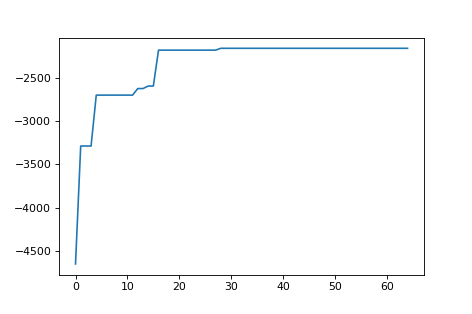

In [1546]:
plt.figure()
plt.plot(checker.bests)

In [1547]:
study.best_params

{'power_SF': 2.3685256998407294,
 'power_NN': 0.6601354314407113,
 'power_SWT': 0.8846833948954054,
 'p_norm': -7.943578946574049,
 'sig_SF_kwargs_mu': 0.20782839783639465,
 'sig_SF_kwargs_b': 0.12521192187490504,
 'sig_NN_kwargs_mu': 0.10306483364904168,
 'sig_NN_kwargs_b': 0.7224723298218996,
 'sig_SWT_kwargs_mu': -0.42332028846140457,
 'sig_SWT_kwargs_b': 0.7502365500747712}

In [1548]:
best_params = study.best_params.copy()
[best_params.pop(p) for p in [
    'sig_SF_kwargs_mu',
    'sig_SF_kwargs_b',
    'sig_NN_kwargs_mu',
    'sig_NN_kwargs_b',
    'sig_SWT_kwargs_mu',
    'sig_SWT_kwargs_b']]
best_params['sig_SF_kwargs'] = {'mu': study.best_params['sig_SF_kwargs_mu'],
                                'b': study.best_params['sig_SF_kwargs_b'],}
best_params['sig_NN_kwargs'] = {'mu': study.best_params['sig_NN_kwargs_mu'],
                                'b': study.best_params['sig_NN_kwargs_b'],}
best_params['sig_SWT_kwargs'] = {'mu': study.best_params['sig_SWT_kwargs_mu'],
                                 'b': study.best_params['sig_SWT_kwargs_b'],}
kwargs_makeConjunctiveDistanceMatrix_best = best_params


In [1549]:
kwargs_makeConjunctiveDistanceMatrix_best

{'power_SF': 2.3685256998407294,
 'power_NN': 0.6601354314407113,
 'power_SWT': 0.8846833948954054,
 'p_norm': -7.943578946574049,
 'sig_SF_kwargs': {'mu': 0.20782839783639465, 'b': 0.12521192187490504},
 'sig_NN_kwargs': {'mu': 0.10306483364904168, 'b': 0.7224723298218996},
 'sig_SWT_kwargs': {'mu': -0.42332028846140457, 'b': 0.7502365500747712}}

In [1550]:
clusterer.best_params

{'power_SF': 2.1225515540392443,
 'power_NN': 0.15239439045189962,
 'power_SWT': 0.8982503595091178,
 'p_norm': -8.653077456584777,
 'sig_SF_kwargs': {'mu': 0.2952369397306444, 'b': 1.9170557475931949},
 'sig_NN_kwargs': {'mu': 0.344580616681926, 'b': 1.7001621655664223},
 'sig_SWT_kwargs': {'mu': 0.16616200198055492, 'b': 0.12122283467970872}}

In [1563]:
d, _, _, _, _ = clusterer.make_conjunctive_distance_matrix(
    s_sf=clusterer.s_sf_pruned,
    s_NN=clusterer.s_NN_pruned,
    s_SWT=clusterer.s_SWT_pruned,
#     **kwargs_makeConjunctiveDistanceMatrix_best
#     **clusterer.kwargs_makeConjunctiveDistanceMatrix_best
    **{
        'power_SF': 1.0,
        'power_NN': 2.0,
        'power_SWT': 0.1,
        'p_norm': -2.0,
        'sig_SF_kwargs': None,
        'sig_NN_kwargs': {'mu':0.5, 'b':0.5},
        'sig_SWT_kwargs': {'mu':0.5, 'b':0.5},
    },
)


In [1625]:
clusterer.fit(
    session_bool=data.sessionID_concat,
    min_cluster_size=2,
    split_intraSession_clusters=False,
    discard_failed_pruning=True,
    d_conj=d,
    d_cut=clusterer.d_cutoff,
    d_step=0.05,
)

Clustering...
Fitting HDBSCAN...


(array([3266,   -1,  291, ...,   -1, 2863,   -1]),
 HDBSCAN(algorithm='generic', alpha=0.999, max_cluster_size=14,
         metric='precomputed', min_cluster_size=2))

In [1626]:
labels = clusterer.labels.copy()

In [1627]:
clusterer.hdbs.labels_.shape

(51170,)

In [1628]:
labels.shape

(51169,)

In [1629]:
clusterer.violations_labels.shape

(1129,)

In [1633]:
u = np.unique(clusterer.violations_labels)
len(u)

1129

In [1636]:
u = np.unique(labels)
len(u)

6485

In [729]:
# results_clustering = clustering.score_labels(clusterer.labels, ucids_groundTruth, ignore_negOne=False)
# print(f"Accuracy score: {results_clustering['score_weighted_partial']}")

# # results_clustering

# print(len(np.unique(labels)), len(np.unique(ucids_groundTruth)))
# print((labels==-1).sum())
# print((ucids_groundTruth==-1).sum())

# Visualize results

In [810]:
FOV_clusters = visualization.compute_colored_FOV(
    spatialFootprints=aligner.ROIs_aligned,
    FOV_height=data.FOV_height,
    FOV_width=data.FOV_width,
    boolSessionID=data.sessionID_concat,
    labels=labels,
    confidence=None,
)

<IPython.core.display.Javascript object>


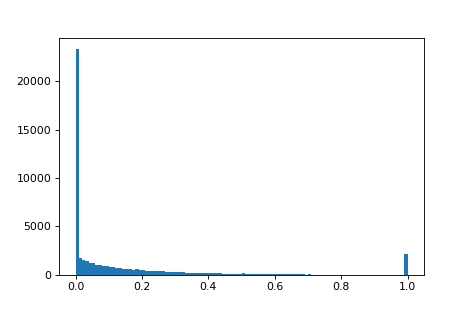

In [1637]:
plt.figure()
plt.hist(clusterer.hdbs.outlier_scores_, 100);

<IPython.core.display.Javascript object>


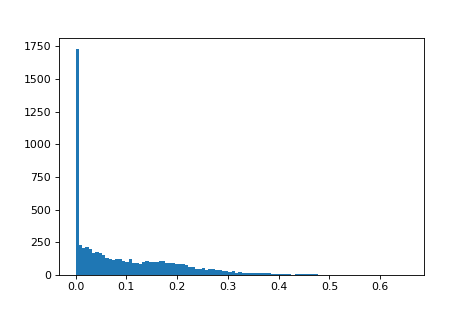

In [1638]:
plt.figure()
plt.hist(clusterer.hdbs.cluster_persistence_, 100);

<IPython.core.display.Javascript object>


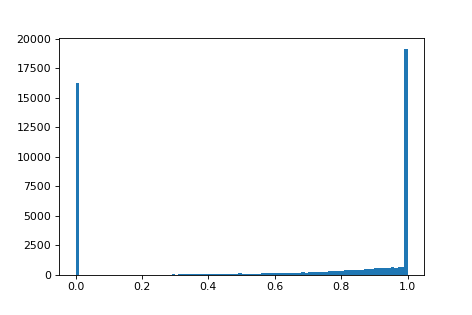

In [1639]:
plt.figure()
plt.hist(clusterer.hdbs.probabilities_, 100);

In [1640]:
clusterer.hdbs.probabilities_.shape

(51170,)

In [1641]:
clusterer.hdbs.cluster_persistence_.shape

(6484,)

In [1642]:
labels2 = labels.copy()
labels2[clusterer.hdbs.probabilities_[:-1] < 0.95] = -1

In [1513]:
labels2 = labels.copy()
labels2[np.isin(labels, np.where(clusterer.hdbs.cluster_persistence_[:-1] < 0.97)[0])] = -1

In [1428]:
labels2 = labels.copy()
labels2[np.isin(labels, np.where(clusterer.hdbs.outlier_scores_[:-1] < 0.95)[0])] = -1

In [1578]:
np.isin(u[c < 5], labels2).shape

array([ True,  True,  True, ...,  True,  True,  True])

In [1579]:
u, c = np.unique(labels2, return_counts=True)
labels2[np.isin(labels2, u[c < 5])] = -1

In [1643]:
FOV_clusters = visualization.compute_colored_FOV(
    spatialFootprints=aligner.ROIs_aligned,
    FOV_height=data.FOV_height,
    FOV_width=data.FOV_width,
    boolSessionID=data.sessionID_concat,
    labels=labels2,
    confidence=None,
)

<IPython.core.display.Javascript object>


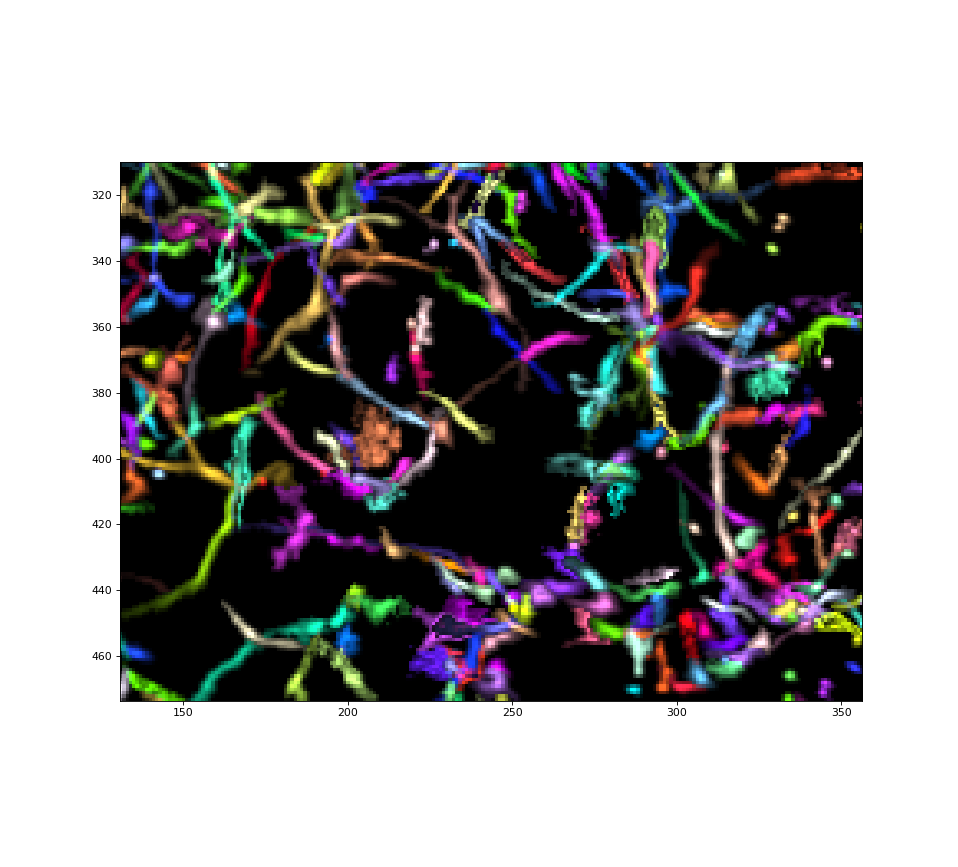

interactive(children=(IntSlider(value=0, description='i_frame', max=13), Output()), _dom_classes=('widget-inte…

In [1644]:
%matplotlib notebook
visualization.display_toggle_image_stack(FOV_clusters)

In [266]:
# visualization.display_toggle_image_stack(aligner.get_ROIsAligned_maxIntensityProjection())

In [54]:
import scipy
from tqdm import tqdm

In [57]:
h, w = data.FOV_height, data.FOV_width

boolSessionID = data.sessionID_concat

rois = scipy.sparse.vstack(aligner.ROIs_aligned)
rois = rois.multiply(1.2/rois.max(1).A).power(1)

u, c = np.unique(labels, return_counts=True)

n_c = len(u)
n_p = rois.shape[1]

colors = helpers.rand_cmap(nlabels=n_c, verbose=False)(np.linspace(0.,1.,n_c, endpoint=False))

if np.isin(-1, labels):
    colors[0] = [0,0,0,0]

labels_squeezed = helpers.squeeze_integers(labels)
labels_squeezed -= labels_squeezed.min()

rois_c = scipy.sparse.hstack([rois.multiply(colors[labels_squeezed, ii][:,None]) for ii in range(4)]).tocsr()
rois_c.data = np.minimum(rois_c.data, 1)

rois_c_bySessions = [rois_c[idx] for idx in boolSessionID.T]

rois_c_bySessions_FOV = [r.max(0).toarray().reshape(4, h, w).transpose(1,2,0)[:,:,:3] for r in rois_c_bySessions]


<IPython.core.display.Javascript object>


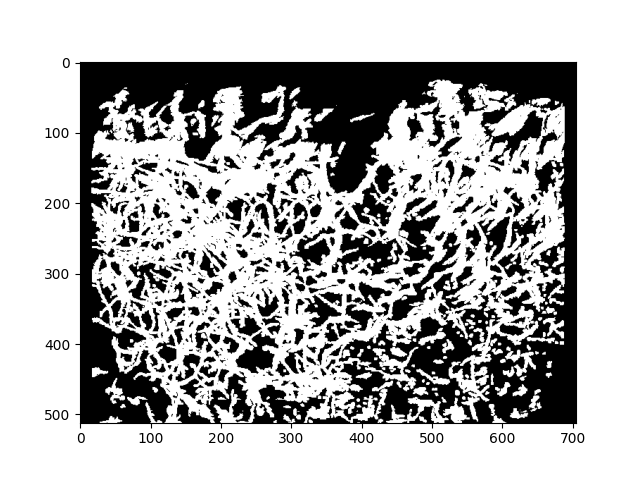

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


interactive(children=(IntSlider(value=0, description='i_frame', max=13), Output()), _dom_classes=('widget-inte…

In [56]:
visualization.display_toggle_image_stack(rois_c_bySessions_FOV)

/tmp/ipykernel_105903/2932124649.py:23: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure(figsize=(40,1))


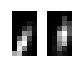

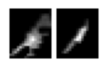

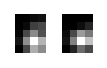

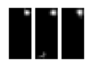

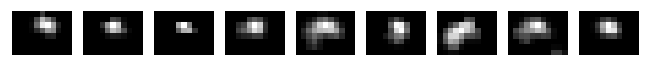

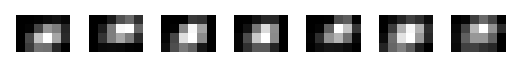

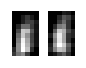

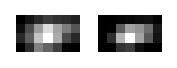

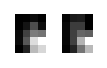

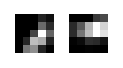

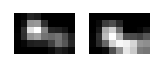

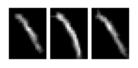

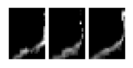

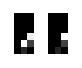

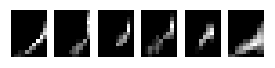

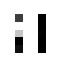

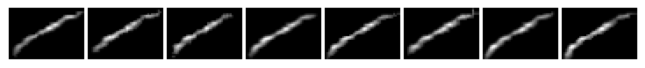

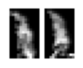

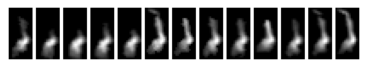

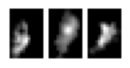

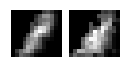

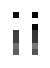

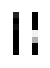

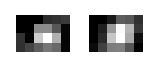

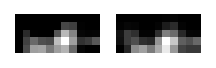

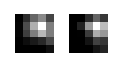

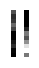

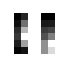

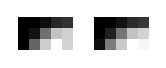

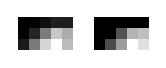

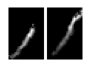

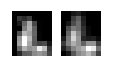

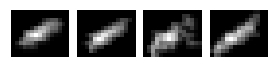

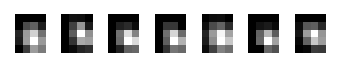

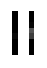

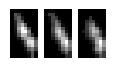

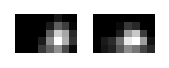

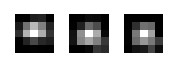

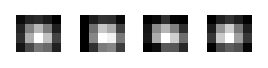

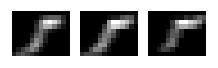

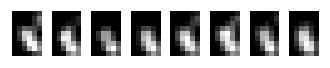

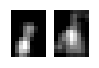

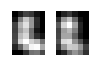

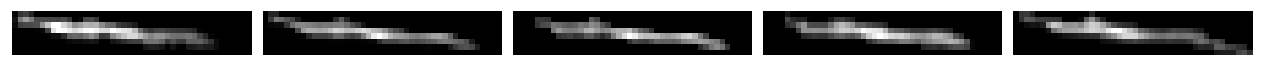

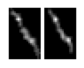

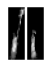

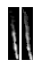

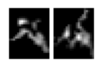

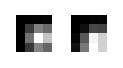

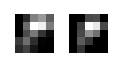

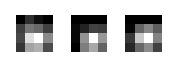

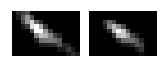

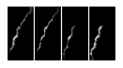

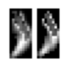

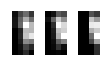

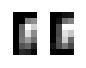

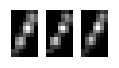

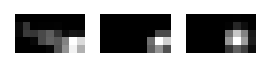

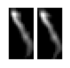

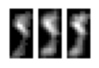

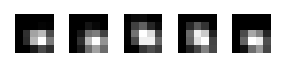

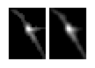

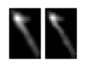

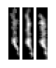

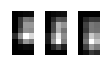

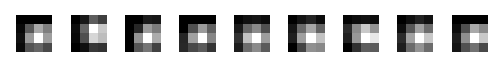

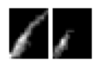

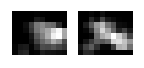

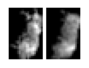

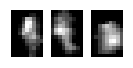

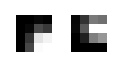

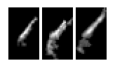

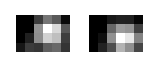

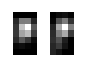

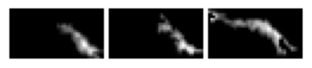

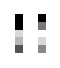

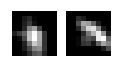

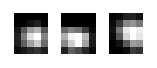

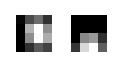

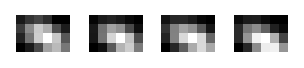

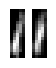

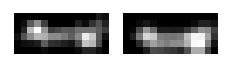

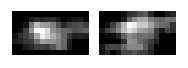

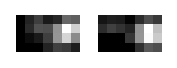

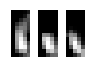

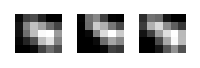

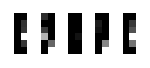

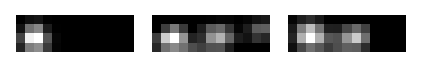

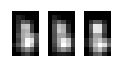

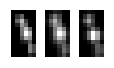

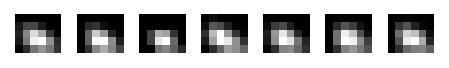

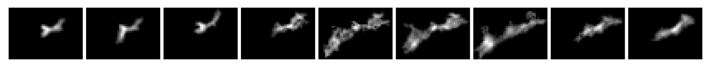

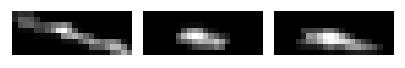

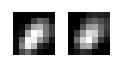

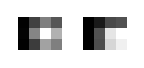

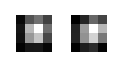

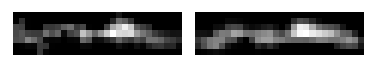

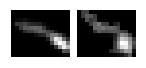

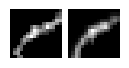

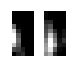

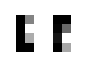

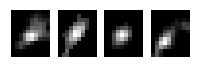

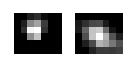

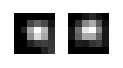

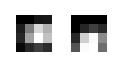

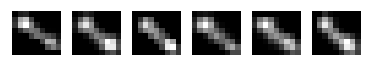

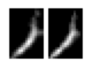

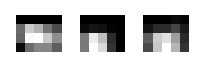

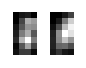

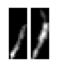

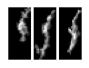

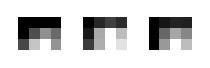

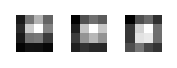

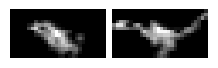

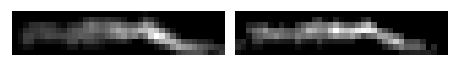

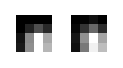

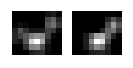

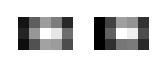

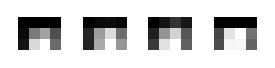

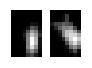

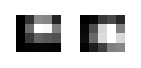

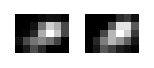

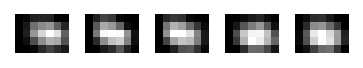

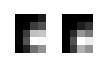

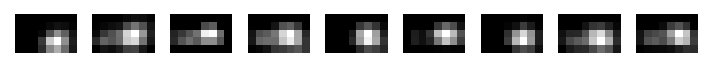

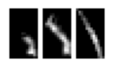

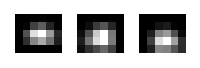

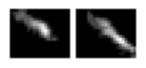

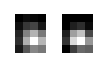

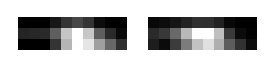

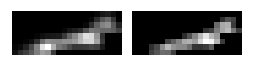

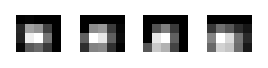

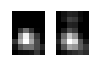

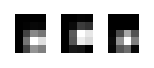

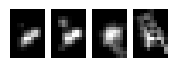

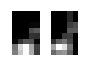

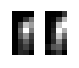

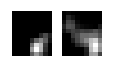

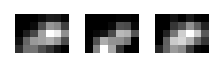

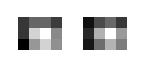

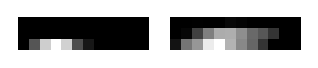

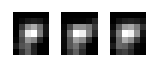

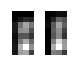

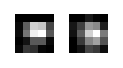

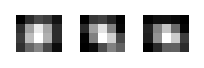

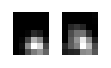

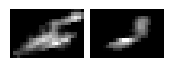

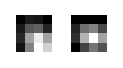

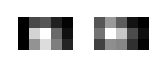

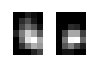

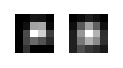

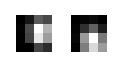

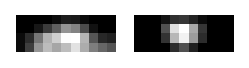

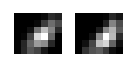

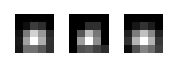

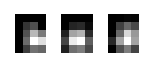

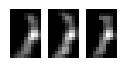

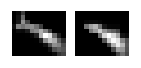

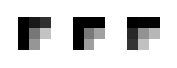

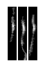

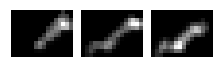

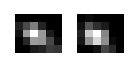

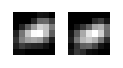

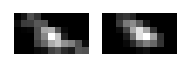

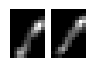

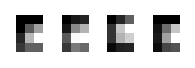

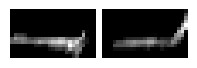

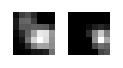

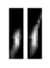

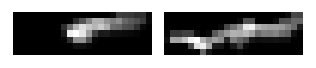

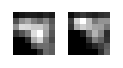

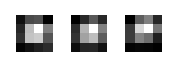

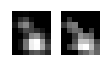

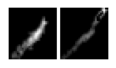

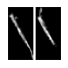

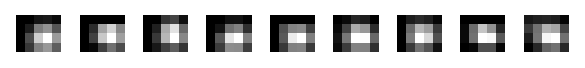

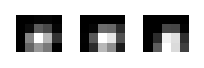

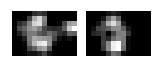

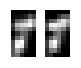

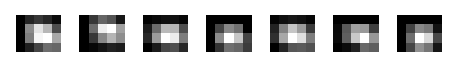

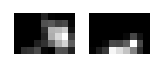

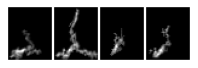

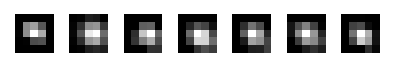

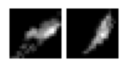

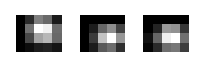

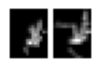

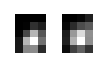

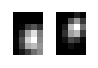

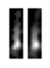

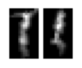

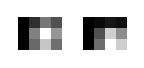

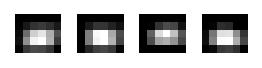

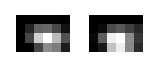

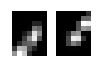

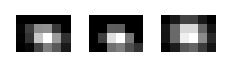

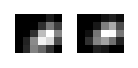

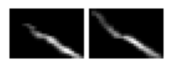

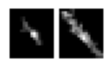

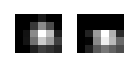

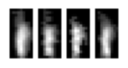

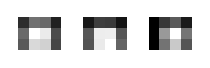

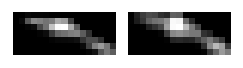

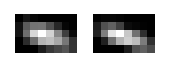

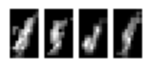

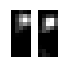

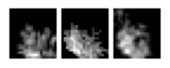

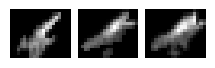

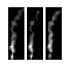

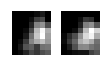

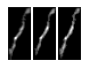

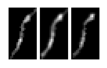

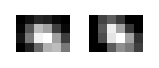

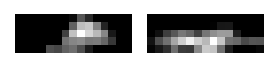

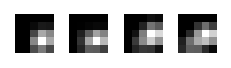

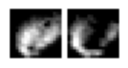

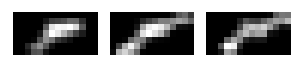

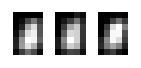

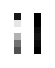

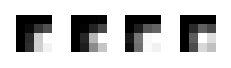

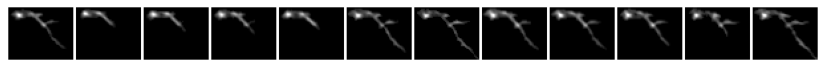

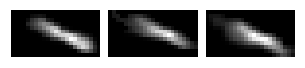

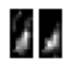

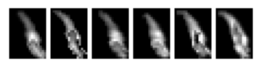

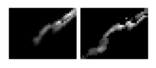

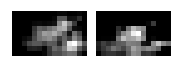

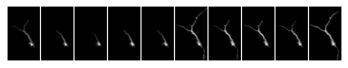

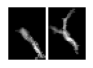

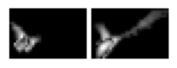

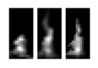

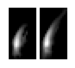

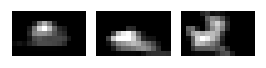

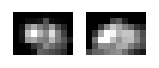

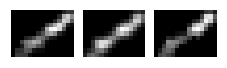

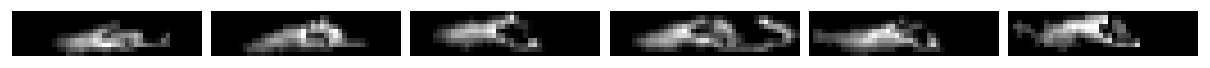

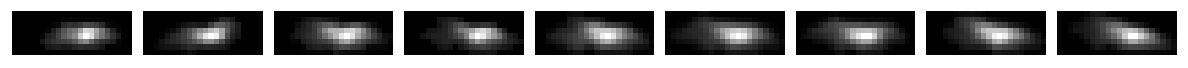

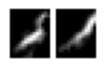

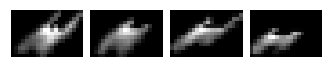

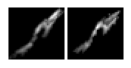

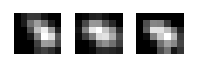

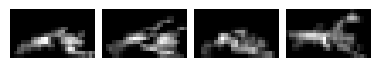

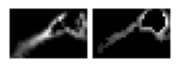

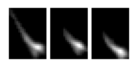

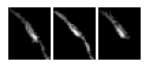

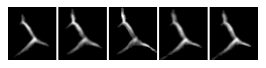

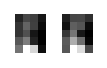

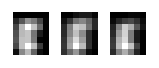

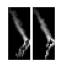

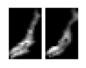

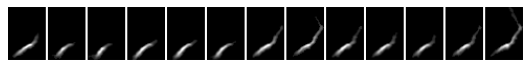

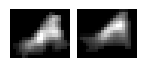

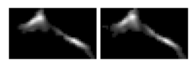

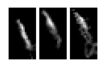

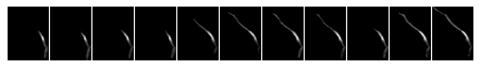

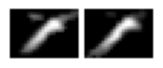

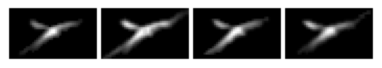

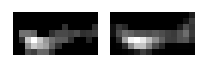

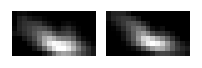

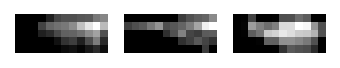

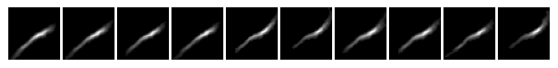

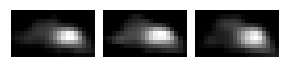

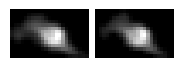

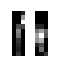

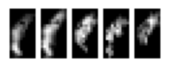

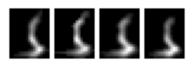

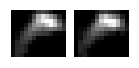

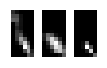

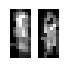

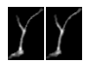

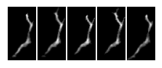

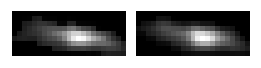

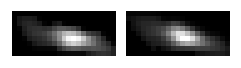

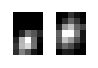

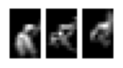

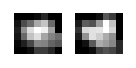

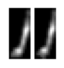

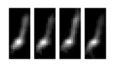

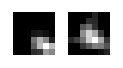

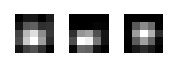

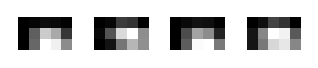

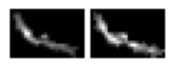

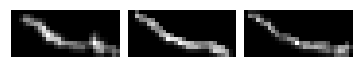

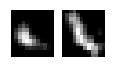

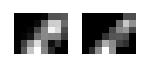

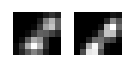

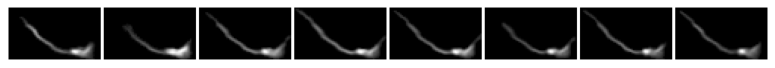

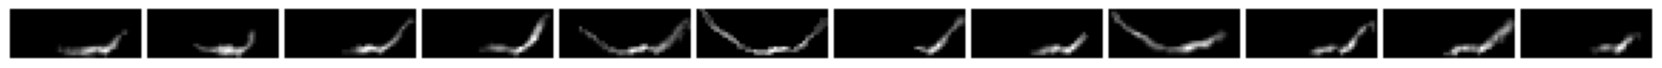

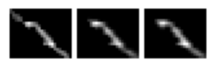

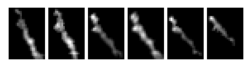

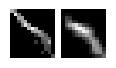

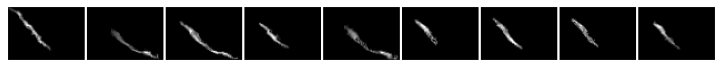

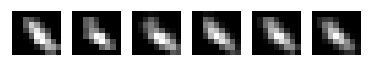

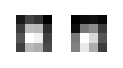

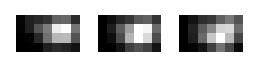

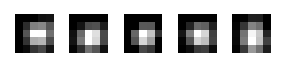

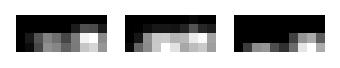

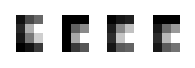

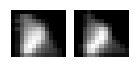

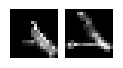

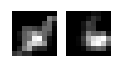

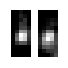

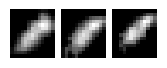

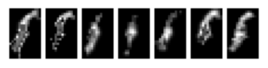

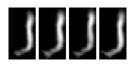

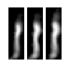

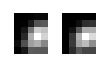

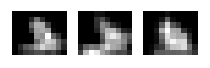

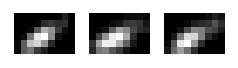

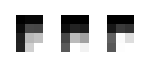

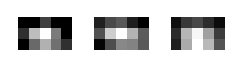

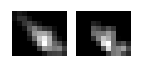

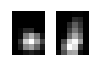

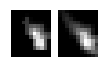

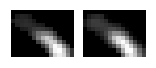

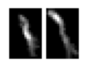

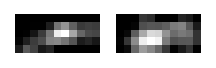

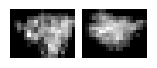

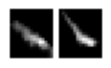

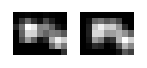

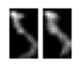

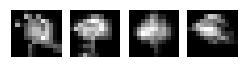

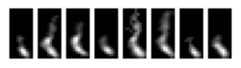

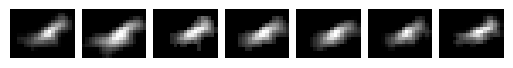

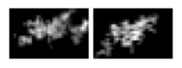

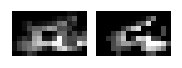

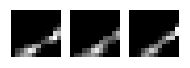

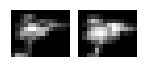

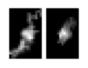

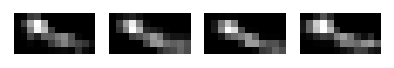

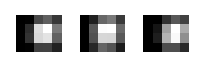

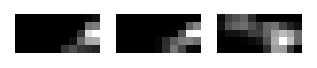

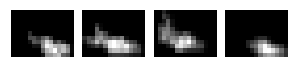

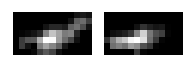

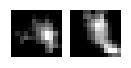

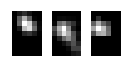

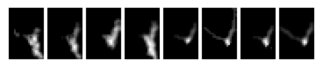

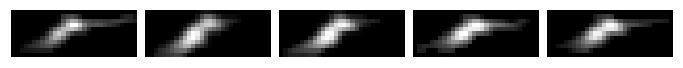

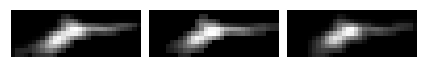

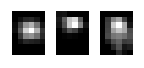

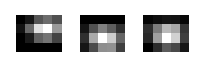

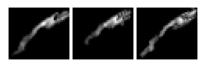

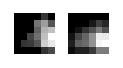

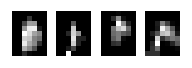

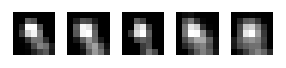

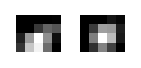

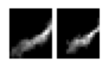

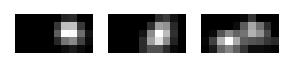

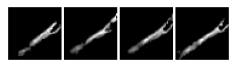

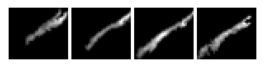

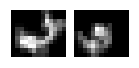

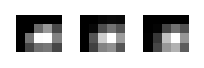

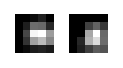

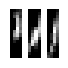

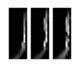

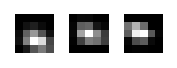

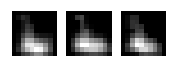

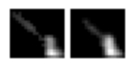

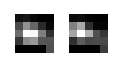

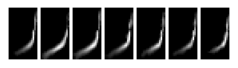

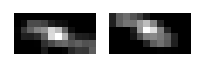

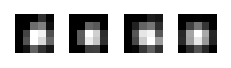

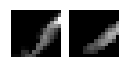

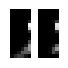

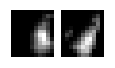

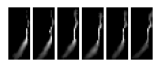

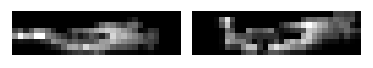

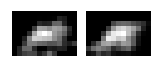

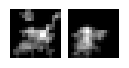

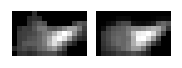

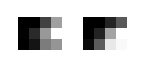

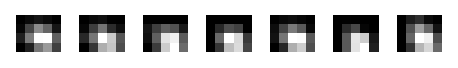

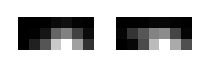

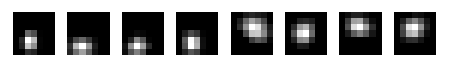

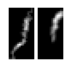

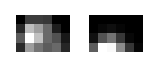

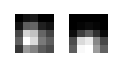

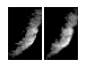

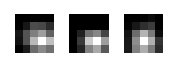

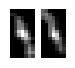

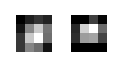

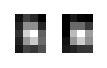

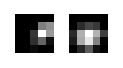

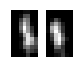

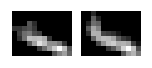

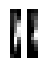

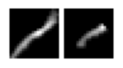

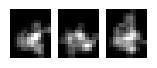

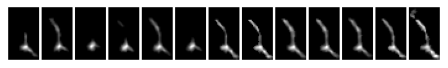

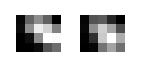

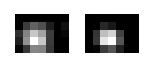

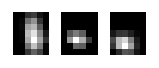

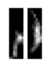

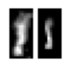

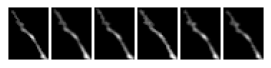

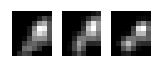

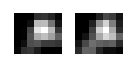

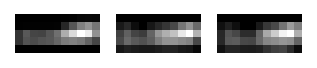

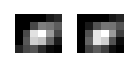

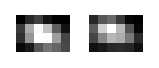

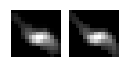

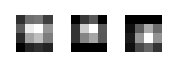

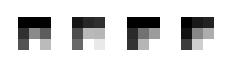

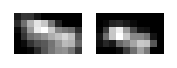

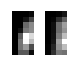

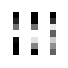

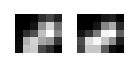

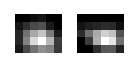

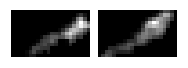

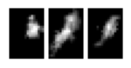

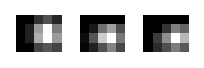

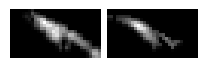

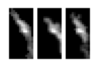

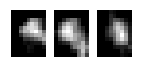

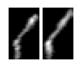

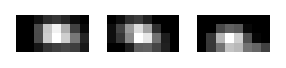

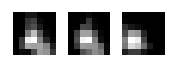

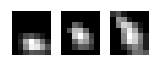

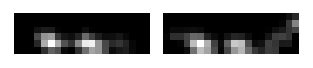

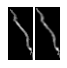

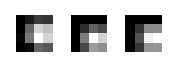

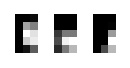

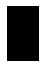

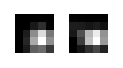

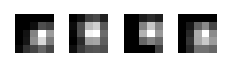

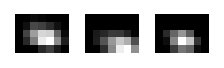

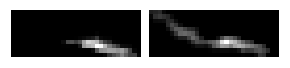

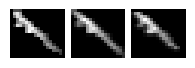

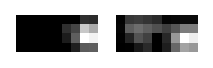

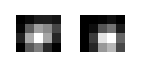

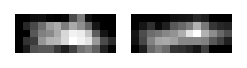

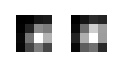

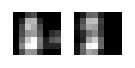

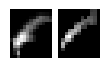

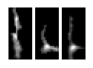

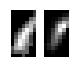

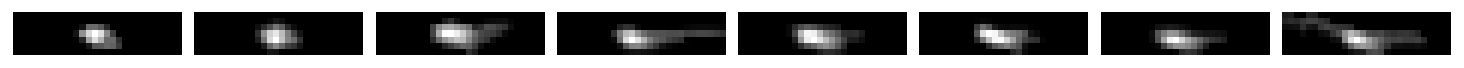

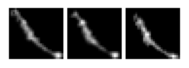

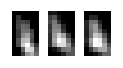

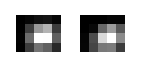

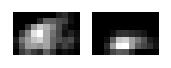

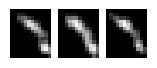

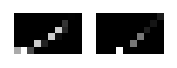

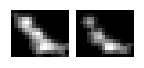

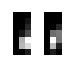

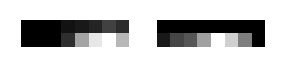

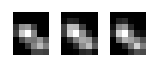

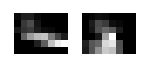

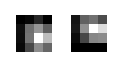

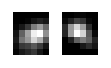

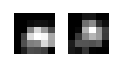

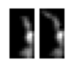

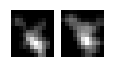

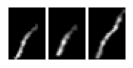

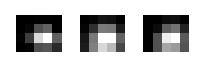

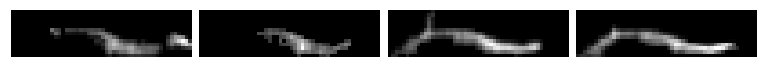

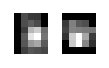

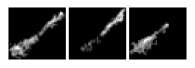

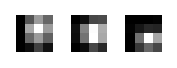

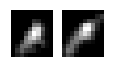

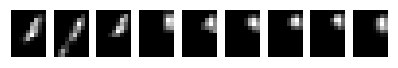

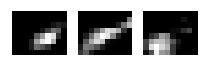

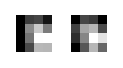

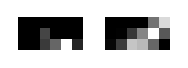

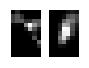

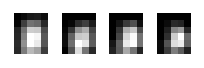

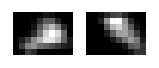

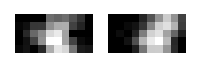

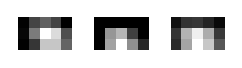

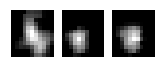

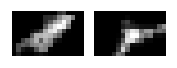

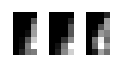

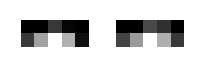

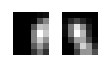

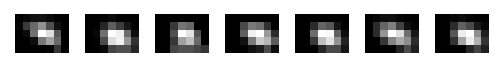

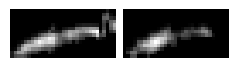

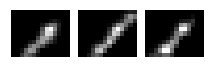

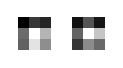

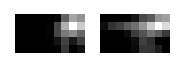

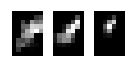

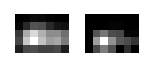

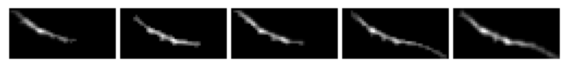

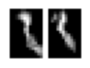

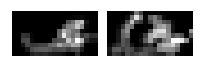

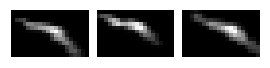

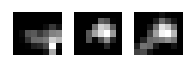

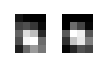

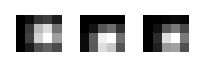

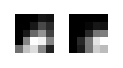

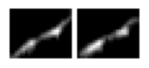

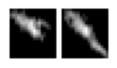

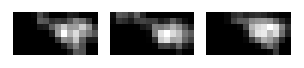

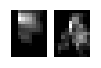

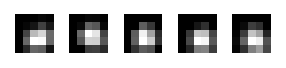

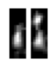

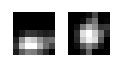

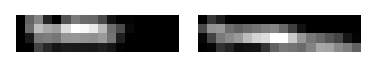

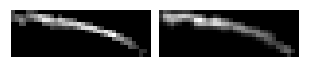

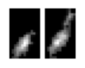

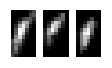

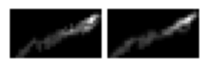

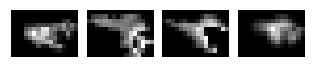

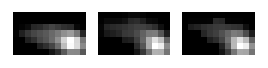

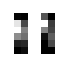

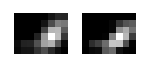

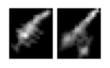

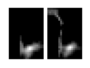

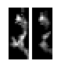

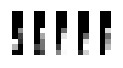

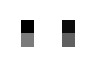

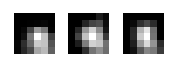

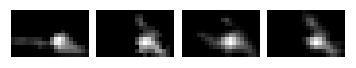

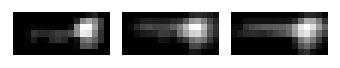

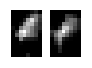

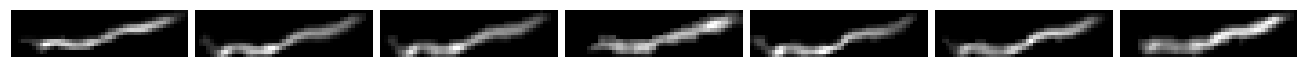

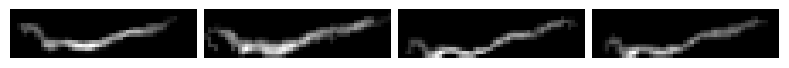

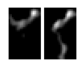

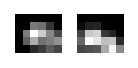

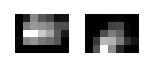

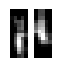

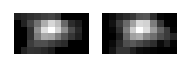

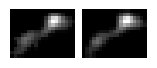

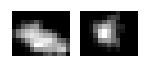

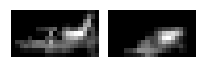

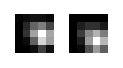

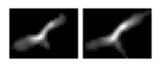

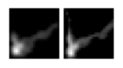

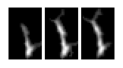

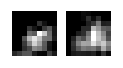

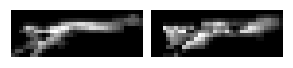

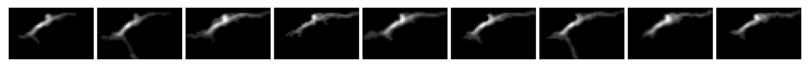

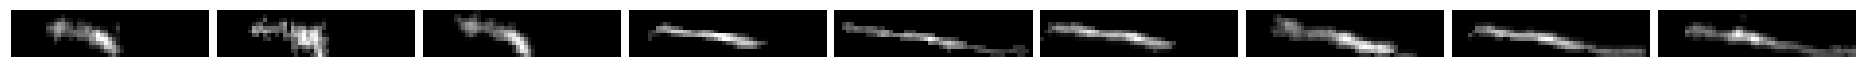

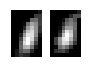

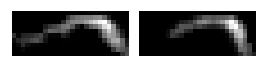

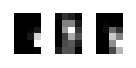

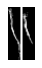

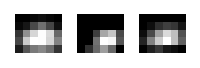

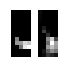

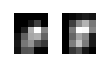

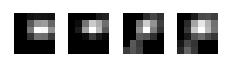

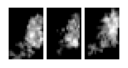

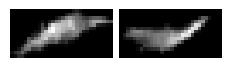

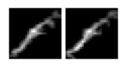

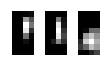

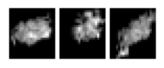

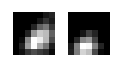

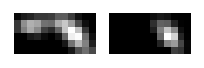

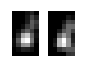

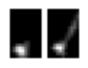

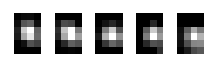

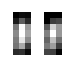

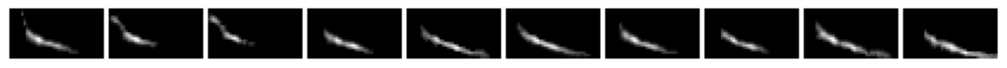

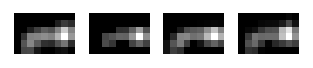

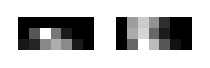

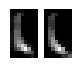

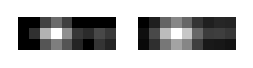

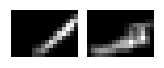

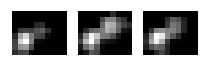

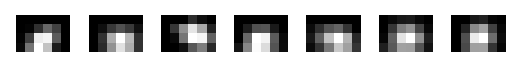

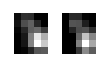

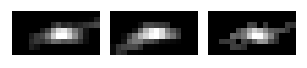

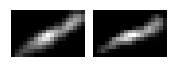

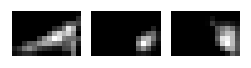

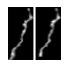

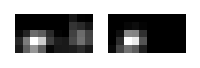

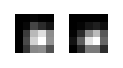

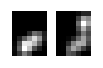

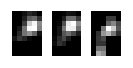

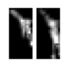

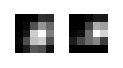

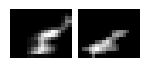

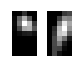

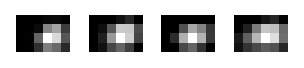

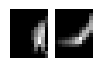

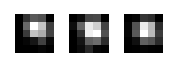

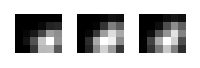

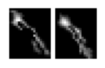

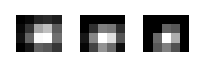

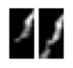

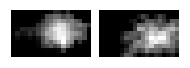

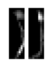

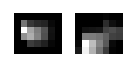

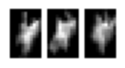

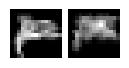

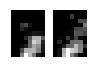

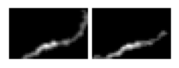

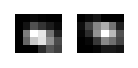

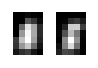

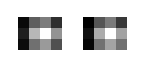

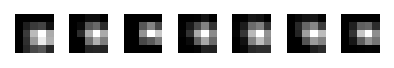

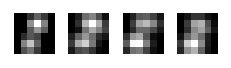

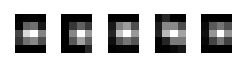

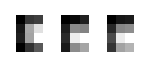

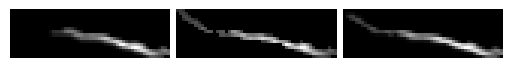

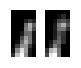

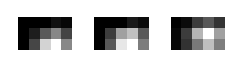

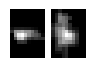

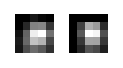

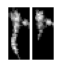

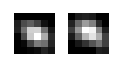

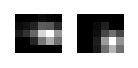

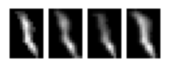

In [1572]:
import scipy.sparse

ucids = labels2.copy()
# ucids = ucids[ucids==975]
ucids_unique = np.unique(ucids[ucids>-1])

# ROI_ims = np.concatenate(data.ROI_images, axis=0)
ROI_ims_sparse = scipy.sparse.vstack(aligner.ROIs_aligned)
ROI_ims_sparse = ROI_ims_sparse.multiply( ROI_ims_sparse.max(1).power(-1) ).tocsr()


ucid_sfCat = []
for ucid in ucids_unique:
    idx = np.where(ucids == ucid)[0]
    ucid_sfCat.append( np.concatenate(list(visualization.crop_cluster_ims(ROI_ims_sparse[idx].toarray().reshape(len(idx), data.FOV_height, data.FOV_width))), axis=1) )
#     ucid_sfCat.append( np.concatenate(list(ROI_ims_sparse[idx].toarray().reshape(len(idx), data.FOV_height, data.FOV_width)), axis=1) )
# data.ROI_images[i_sesh][idx] for 


%matplotlib inline

for sf in ucid_sfCat[:600]:
    plt.figure(figsize=(40,1))
    plt.imshow(sf, cmap='gray')
    plt.axis('off')

<IPython.core.display.Javascript object>


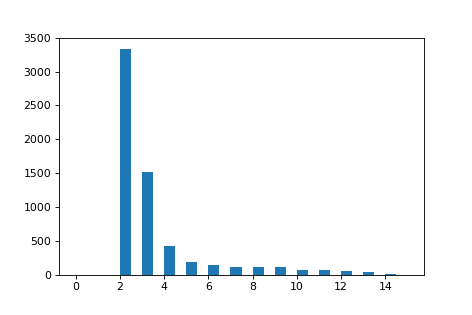

In [1584]:
_, counts = np.unique(ucids, return_counts=True)

plt.figure()
plt.hist(counts, 30, range=(0, data.n_sessions+1));


# Save results

In [129]:
dir_save = Path('/home/rich/Desktop/').resolve()
name_save = dir_allOuterFolders.name
path_save = dir_save / (name_save + '.ROICaT.results' + '.pkl')

In [143]:
ROIs = {
    "ROIs_aligned": aligner.ROIs_aligned,
    "ROIs_raw": data.spatialFootprints,
    "frame_height": data.FOV_height,
    "frame_width": data.FOV_width,
    "idx_roi_session": np.where(data.sessionID_concat)[1]
}

results = {
    "UCIDs": labels,
    "UCIDs_bySession": labels_bySession,
    "ROIs": ROIs,
}

helpers.simple_save(
    obj=results,
    filename=path_save,
    mkdir=True,
)

In [115]:
import scipy.io

In [116]:
test = scipy.io.loadmat('/media/rich/bigSSD/other lab data/Harvey_lab_ROIs/NOAH_alignment_ground_truth/NY044_manually_aligned.mat', simplify_cells=True)

In [117]:
test['this_mouse']['ud']['sismat']

array([[ nan,  nan, 282., ...,  63.,  70.,  77.],
       [ 85., 359.,  nan, ...,  nan,  nan,  nan],
       [399.,  70.,  nan, ...,  nan,  nan,  nan],
       ...,
       [182., 310.,  nan, ..., 161., 324., 335.],
       [511.,  nan,  nan, ...,  nan,  nan,  nan],
       [ nan,  nan,  nan, ...,  nan,  nan,  nan]])

In [118]:
sismat = test['this_mouse']['ud']['sismat']

In [119]:
ucid_gt = [np.ones(data.n_roi[ii])*-1 for ii in range(data.n_sessions)]

for sesh in range(sismat.shape[1]):
    for ii in range(sismat.shape[0]):
        idx = sismat[:,sesh][ii] -1
        if np.isnan(idx) == False:
#             print(sesh, idx, ii)
            ucid_gt[sesh][int(idx)] = ii

In [120]:
_, counts = np.unique(np.concatenate(ucid_gt), return_counts=True)

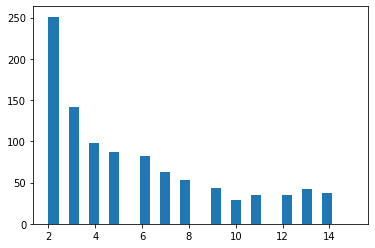

In [123]:
plt.figure()
plt.hist(counts, 30, range=(2, data.n_sessions+1));

<IPython.core.display.Javascript object>


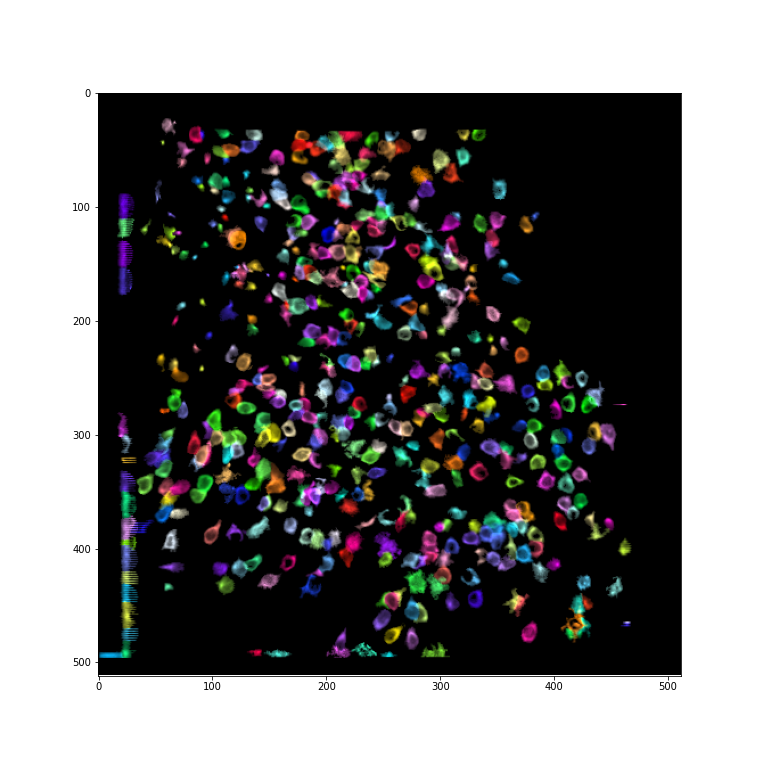

interactive(children=(IntSlider(value=0, description='i_frame', max=13), Output()), _dom_classes=('widget-inte…

In [367]:
FOV_clusters = visualization.compute_colored_FOV(
    spatialFootprints=aligner.ROIs_aligned,
    FOV_height=data.FOV_height,
    FOV_width=data.FOV_width,
    preds=np.concatenate(ucid_gt),
    confidence=None,
    threshold_confidence = 0.5
)

visualization.display_toggle_image_stack(FOV_clusters)

In [ ]:
np.random.normal()

<IPython.core.display.Javascript object>


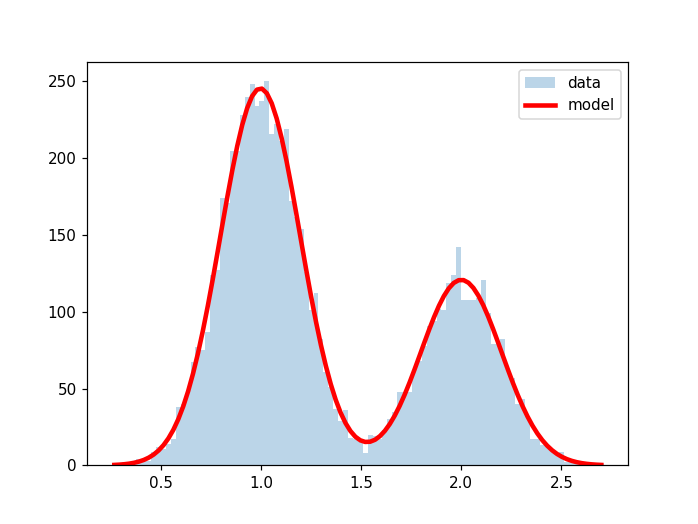

[9.97421912e-01 1.99759951e-01 2.45497064e+02 2.00006200e+00
 2.02499854e-01 1.20828308e+02] 
 [2.24550472e-03 2.25814749e-03 2.38938955e+00 4.59344291e-03
 4.61978447e-03 2.37326641e+00]


In [70]:
# from pylab import *
import scipy.optimize
plt.figure()

data=np.concatenate((np.random.normal(1,.2,5000),np.random.normal(2,.2,2500)))
y,x,_=plt.hist(data,100,alpha=.3,label='data')

x=(x[1:]+x[:-1])/2 # for len(x)==len(y)

def gauss(x,mu,sigma,A):
    return A*np.exp(-(x-mu)**2/2/sigma**2)

def bimodal(x,mu1,sigma1,A1,mu2,sigma2,A2):
    return gauss(x,mu1,sigma1,A1)+gauss(x,mu2,sigma2,A2)

expected=(1,.2,250,2,.2,125)
params,cov=scipy.optimize.curve_fit(bimodal,x,y,expected)
sigma=np.sqrt(cov.diagonal())

plt.plot(x,bimodal(x,*params),color='red',lw=3,label='model')
plt.legend()
print(params,'\n',sigma)    